# RR-MR transtion criteria

In [10]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
from scipy import interpolate as scipolate
import intersection 


def phi(theta, M):
    out = optimize.fsolve(lambda x: fun(x,M,theta),0.01)
    out = np.append(out, optimize.fsolve(lambda x: fun(x,M,theta),np.pi/2))
    return out
def theta(x,M):
    out = 2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2)
    out = np.arctan(out)
    return out
def fun(x,M,theta):
    f=np.tan(theta)-2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2)
    return f
def fun2(x,M):
    theta=np.arctan(2*(1/np.tan(x))*(M**2*(np.sin(x))**2-1)/(M**2*(1.4+np.cos(2*x))+2))
    return theta
def thetaMax(M):
    phi=optimize.fmin(lambda x: -fun2(x,M),1e-3)
    theta=fun2(phi,M)
    return theta

class state(object):
  def __init__(self,p=100000,M=1.5,T=300,R=287,phi=0,gamma=1.4):
    self.p=p
    self.M=M
    self.T=T
    self.gamma=gamma
    self.phi=phi
    self.R=R
    self.rho=self.p/(self.R*self.T)
    self.u=self.M*np.sqrt(self.gamma*self.R*self.T)
    
def oblique(state0,theta1=10*np.pi/180,weak='True'):
  #theta=theta
  p=phi(theta1,state0.M)
  tmax=thetaMax(state0.M)
  print("Theta max :",tmax*180/np.pi)
  if tmax<theta1:
        print("Shock detached")
  else:
    if weak=='True':
      ph=p[0]
    else:
      ph=p[1]
    M1=np.sqrt((1+(state0.gamma-1)*0.5*(state0.M*np.sin(ph))**2)/(state0.gamma*(state0.M*np.sin(ph))**2-(state0.gamma-1)*0.5))/(np.sin(ph-theta1))
    p2=state0.p*(1+2*state0.gamma*((state0.M*np.sin(ph))**2-1)/(1+state0.gamma))
    T2=state0.T*(p2/state0.p)*(2+(state0.gamma-1)*(state0.M*np.sin(ph))**2)/((1+state0.gamma)*(state0.M*np.sin(ph))**2)
    state1=state(M=M1,p=p2,T=T2)
    state1.phi = ph
    state1.theta= theta1
    return state1

def ST(state0,theta1):
  state1=oblique(state0,theta1=theta1)
  if theta1<thetaMax(state1.M):
        print("This case is a Regular reflection")
        print("Solving using 2 shock theory . . .")
        state2=oblique(state1,theta1=theta1)
        return state1,state2
  else:
    print("This case is a Mach reflection")
    print("Solving for the Standard solution using 3 shock theory...")
    phi = ThreeST(state0,state1,theta1)
    phi2 = phi[0]
    phi3 = phi[1]
    theta2 = theta(phi2,state1.M)
    print(theta2*180/np.pi)
    theta3 = theta(phi3,state0.M)
    state3 = oblique(state0,theta1=theta3)
    state3.phi = phi3
    state3.theta = theta3
    state2 = oblique(state1,theta1=theta2)
    state2.phi = phi2
    state2.theta =theta2
    return state1,state2,state3

def ThreeST(state0,state1,theta):
    p = np.array([[]])
    p = np.append(p,state0.M)  # M0
    p = np.append(p,state1.M)  # M1
    p = np.append(p,theta)  # theta
    p = np.append(p,state1.p/state0.p) # p1/p0
    return optimize.fsolve(lambda x: fun3(x,p),100*np.array([0.01,0.01]))
    
def fun3(x,p,gamma = 1.4):
    """
    x[0] - phi2
    x[1] - phi3
    """
    f=np.array([])
    f=np.append(f,(1+2*(p[1]**2*np.sin(x[0])**2-1)*gamma/(gamma+1))*p[3]-(1+2*(p[0]**2*np.sin(x[1])**2-1)*gamma/(gamma+1)))
    f=np.append(f,p[2]-theta(x[0],p[1])-theta(x[1],p[0]))
    return f
    
    
def polar(M0,both = 'True',type ='p', positive='True',gamma=1.4):
    tmax = thetaMax(M0)
    print("ThetaMax:", tmax*180/np.pi)
    theta = np.linspace(0,tmax,100)
    if type == 'p':
      pWeak = np.asarray([pRatio(k,M0) for k in theta])
      pStrong = np.asarray([pRatio(k,M0,weak = 'False') for k in theta])
    elif type == 'M':
      pWeak = np.asarray([Mj(k,M0) for k in theta])
      pStrong = np.asarray([Mj(k,M0,weak = 'False') for k in theta])
    elif type == 'rho':
      pWeak = np.asarray([rho(k,M0) for k in theta])
      pStrong = np.asarray([rho(k,M0,weak = 'False') for k in theta])
    elif type == 'T':
      pWeak = np.asarray([pRatio(k,M0)/rho(k,M0) for k in theta])
      pStrong = np.asarray([pRatio(k,M0,weak = 'False')/rho(k,M0,weak = 'False') for k in theta])  
    theta = np.append(theta,np.flipud(theta))
    p = np.append(pWeak,np.flipud(pStrong))
    if both =='True':
       p = np.append(p,np.flipud(p))
       theta = np.append(theta,np.flipud(-theta))
    return theta, p

def plot(theta,p,label):
    for k,j,m in zip(theta,p,label):
        plt.plot(theta[k]*180/np.pi,p[j],label=label[m])
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel('theta')
    plt.savefig("output.eps", format='eps', dpi=1000)
    plt.show()
  
   
def Mj(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    Mj=np.sqrt((1+(gamma-1)*0.5*(M*np.sin(z))**2)/(gamma*(M*np.sin(z))**2-(gamma-1)*0.5))/(np.sin(z-x))
    return Mj

def rho(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    rho=((1+gamma)*(M*np.sin(z))**2)/(2+(gamma-1)*(M*np.sin(z))**2)
    return rho    
    
def pRatio(x,M,gamma =1.4, weak = 'True'):
    y = phi(x,M)
    if weak =='True':
        z = y[0]
    else : 
        z = y[1]
    p = 1+2*gamma*((M*np.sin(z))**2-1)/(1+gamma)
    return p

def pRatioMax(M):
    return optimize.fmin(lambda x: -pRatio(x,M,gamma=1.4),0.1)

def thetaSonic(M):
    type = 'M'
    s0=state(M=M,p=100000, T = 300)
    theta0, M0 = polar(s0,type =type)
    f=scipolate.interp1d(M0[:100], theta0[:100])
    return f(1)

def vNCfunc(M0,theta0):
    state0=state(M=M0)
    theta1, p1 = polar(state0,both = 'True',type ='p', positive='True',gamma=1.4)
    p1max= max(p1)
    print("Max", p1max)
    M1=Mj(theta0, M0)
    print("M1",M1)
    out = p1max-pRatio(theta0,M1,gamma =1.4, weak = 'True')*pRatio(theta0,M0,gamma =1.4, weak = 'True')
    return out

def thetavN(M0):
    return optimize.fmin(lambda x: vNCfunc1(M0,x),1*np.pi/180)

def vNCfunc1(M0,theta0):
    t1 =theta0
    M1u=Mj(t1/180,M0)
    theta1, p1 = polar(M0)
    theta2u, p2u = polar(M1u)
    p1u_= np.interp(t1,theta1[:100],p1[:100])
    y1= p2u*p1u_
    x,y=intersection.intersection(theta1,p1,theta2u[-200:]+t1, y1[-200:])
    #print("Solutions:")
    #print(x[0]*180/np.pi, "degrees :", y[0])
    #print(np.min(x)*180/np.pi, "degrees :", y[-1])
    return x[-1]

In [11]:
thetavN(3.0)*180/np.pi

Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 28
         Function evaluations: 56
ThetaMax: [34.07343974]
Optimization terminated successfully.
         Current function value: -0.594659
         Iterations: 28
         Function evaluations: 56
ThetaMax: [34.07147892]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 28
         Function evaluations: 56
ThetaMax: [34.07343974]
Optimization terminated successfully.
         Current function value: -0.594658
         Iterations: 28
         Function evaluations: 56
ThetaMax: [34.07138087]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 28
         Function evaluations: 56
ThetaMax: [34.07343974]
Optimization terminated successfully.
         Current function value: -0.594661
         Iterations: 28
         Function evaluations: 56
ThetaMax: [34.07157696]
Optimization terminate

IndexError: index -1 is out of bounds for axis 0 with size 0

In [2]:
M0 = np.linspace(1,10,10)
thetaD=[thetaMax(i)*180/np.pi for i in M0]
thetaS=[thetaSonic(i)*180/np.pi for i in M0]
thetavM=[thetavN1(i)*180/np.pi for i in M0]

Optimization terminated successfully.
         Current function value: -1.570702
         Iterations: 39
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -0.023094
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.060582
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.103128
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.147059
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.190366
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.231909
         Iterations: 27
         Function evaluations: 54
Optimization terminated suc

C:\Users\sagar\Anaconda3\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: invalid value encountered in sqrt
C:\Users\sagar\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\sagar\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]



         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.060582
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.103128
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.147059
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.190366
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.231909
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.271074
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.307579
         Iterations: 27
         Function evaluati

         Current function value: -0.749247
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.750476
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.751656
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.752792
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.753884
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.754935
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: -0.755948
         Iterations: 27
         Function evaluations: 54
Optimization terminated successfully.
         Current function v

C:\Users\sagar\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Max 1.0
M1 [1.08040289]
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 6
         Function evaluations: 12
Optimization terminated successfully.
         Current function value: -0.023094
         Iterations: 27
         Function evaluations: 54
Max 1.2217630853994488
M1 [1.02505186]
Optimization terminated successfully.
         Current function value: -0.023094
         Iterations: 27
         Function evaluations: 54
Max 1.2217630853994488
M1 [1.02041567]
Optimization terminated successfully.
         Current function value: -0.023094
         Iterations: 27
         Function evaluations: 54
Max 1.2217630853994488
M1 [1.01542508]
Optimization terminated successfully.
         Current function value: -0.023094
         Iterations: 27
         Function evaluations: 54
Max 1.2217630853994488
M1 [1.01797113]
Optimization terminated successfully.
         Current function value: -0.023094
         Iterations: 27
         Function eva

Max 1.4628099173553721
M1 [1.10677444]
Optimization terminated successfully.
         Current function value: -0.060582
         Iterations: 27
         Function evaluations: 54
Max 1.4628099173553721
M1 [1.10677444]
Optimization terminated successfully.
         Current function value: -0.060582
         Iterations: 27
         Function evaluations: 54
Max 1.4628099173553721
M1 [1.10629983]
Optimization terminated successfully.
         Current function value: 0.167572
         Iterations: 15
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: -0.103128
         Iterations: 27
         Function evaluations: 54
Max 1.7231404958677685
M1 [1.234668]
Optimization terminated successfully.
         Current function value: -0.103128
         Iterations: 27
         Function evaluations: 54
Max 1.7231404958677685
M1 [1.23272266]
Optimization terminated successfully.
         Current function value: -0.103128
         Iterations: 27
        

M1 [1.20881388]
Optimization terminated successfully.
         Current function value: -0.147059
         Iterations: 27
         Function evaluations: 54
Max 2.0027548209366395
M1 [1.18387648]
Optimization terminated successfully.
         Current function value: -0.147059
         Iterations: 27
         Function evaluations: 54
Max 2.0027548209366395
M1 [1.20061773]
Optimization terminated successfully.
         Current function value: -0.147059
         Iterations: 27
         Function evaluations: 54
Max 2.0027548209366395
M1 [1.20881388]
Optimization terminated successfully.
         Current function value: -0.147059
         Iterations: 27
         Function evaluations: 54
Max 2.0027548209366395
M1 [1.20881388]
Optimization terminated successfully.
         Current function value: -0.147059
         Iterations: 27
         Function evaluations: 54
Max 2.0027548209366395
M1 [1.19647792]
Optimization terminated successfully.
         Current function value: -0.147059
         Iter

Max 2.3016528925619832
M1 [1.25670293]
Optimization terminated successfully.
         Current function value: -0.190366
         Iterations: 27
         Function evaluations: 54
Max 2.3016528925619832
M1 [1.25670293]
Optimization terminated successfully.
         Current function value: -0.190366
         Iterations: 27
         Function evaluations: 54
Max 2.3016528925619832
M1 [1.25645956]
Optimization terminated successfully.
         Current function value: -0.190366
         Iterations: 27
         Function evaluations: 54
Max 2.3016528925619832
M1 [1.2566421]
Optimization terminated successfully.
         Current function value: -0.190366
         Iterations: 27
         Function evaluations: 54
Max 2.3016528925619832
M1 [1.2566421]
Optimization terminated successfully.
         Current function value: -0.190366
         Iterations: 27
         Function evaluations: 54
Max 2.3016528925619832
M1 [1.25652041]
Optimization terminated successfully.
         Current function value: -0

M1 [1.25773878]
Optimization terminated successfully.
         Current function value: -0.271074
         Iterations: 27
         Function evaluations: 54
Max 2.957300275482093
M1 [1.10364378]
Optimization terminated successfully.
         Current function value: -0.271074
         Iterations: 27
         Function evaluations: 54
Max 2.957300275482093
M1 [1.10364378]
Optimization terminated successfully.
         Current function value: -0.271074
         Iterations: 27
         Function evaluations: 54
Max 2.957300275482093
M1 [1.18708887]
Optimization terminated successfully.
         Current function value: -0.271074
         Iterations: 27
         Function evaluations: 54
Max 2.957300275482093
M1 [1.32182173]
Optimization terminated successfully.
         Current function value: -0.271074
         Iterations: 27
         Function evaluations: 54
Max 2.957300275482093
M1 [1.38191028]
Optimization terminated successfully.
         Current function value: -0.271074
         Iteration

Optimization terminated successfully.
         Current function value: -0.271074
         Iterations: 27
         Function evaluations: 54
Max 2.957300275482093
M1 [1.35261353]
Optimization terminated successfully.
         Current function value: -0.271074
         Iterations: 27
         Function evaluations: 54
Max 2.957300275482093
M1 [1.35261331]
Optimization terminated successfully.
         Current function value: 0.444306
         Iterations: 30
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: -0.307579
         Iterations: 27
         Function evaluations: 54
Max 3.31404958677686
M1 [1.69316123]
Optimization terminated successfully.
         Current function value: -0.307579
         Iterations: 27
         Function evaluations: 54
Max 3.31404958677686
M1 [1.69145828]
Optimization terminated successfully.
         Current function value: -0.307579
         Iterations: 27
         Function evaluations: 54
Max 3.31404958677

Max 3.31404958677686
M1 [1.39845514]
Optimization terminated successfully.
         Current function value: -0.307579
         Iterations: 27
         Function evaluations: 54
Max 3.31404958677686
M1 [1.39845514]
Optimization terminated successfully.
         Current function value: -0.307579
         Iterations: 27
         Function evaluations: 54
Max 3.31404958677686
M1 [1.39851376]
Optimization terminated successfully.
         Current function value: -0.307579
         Iterations: 27
         Function evaluations: 54
Max 3.31404958677686
M1 [1.39846979]
Optimization terminated successfully.
         Current function value: -0.307579
         Iterations: 27
         Function evaluations: 54
Max 3.31404958677686
M1 [1.39845514]
Optimization terminated successfully.
         Current function value: -0.307579
         Iterations: 27
         Function evaluations: 54
Max 3.31404958677686
M1 [1.39847712]
Optimization terminated successfully.
         Current function value: -0.307579
  

         Function evaluations: 54
Max 3.6900826446280997
M1 [1.43118284]
Optimization terminated successfully.
         Current function value: -0.341347
         Iterations: 27
         Function evaluations: 54
Max 3.6900826446280997
M1 [1.43124246]
Optimization terminated successfully.
         Current function value: -0.341347
         Iterations: 27
         Function evaluations: 54
Max 3.6900826446280997
M1 [1.43136171]
Optimization terminated successfully.
         Current function value: -0.341347
         Iterations: 27
         Function evaluations: 54
Max 3.6900826446280997
M1 [1.43124246]
Optimization terminated successfully.
         Current function value: -0.341347
         Iterations: 27
         Function evaluations: 54
Max 3.6900826446280997
M1 [1.4313319]
Optimization terminated successfully.
         Current function value: -0.341347
         Iterations: 27
         Function evaluations: 54
Max 3.6900826446280997
M1 [1.43127228]
Optimization terminated successfully.


M1 [1.6200463]
Optimization terminated successfully.
         Current function value: -0.400964
         Iterations: 27
         Function evaluations: 54
Max 4.5
M1 [1.49663952]
Optimization terminated successfully.
         Current function value: -0.400964
         Iterations: 27
         Function evaluations: 54
Max 4.5
M1 [1.20168313]
Optimization terminated successfully.
         Current function value: -0.400964
         Iterations: 27
         Function evaluations: 54
Max 4.5
M1 [1.36163552]
Optimization terminated successfully.
         Current function value: -0.400964
         Iterations: 27
         Function evaluations: 54
Max 4.5
M1 [1.6200463]
Optimization terminated successfully.
         Current function value: -0.400964
         Iterations: 27
         Function evaluations: 54
Max 4.5
M1 [1.43108961]
Optimization terminated successfully.
         Current function value: -0.400964
         Iterations: 27
         Function evaluations: 54
Max 4.5
M1 [1.55938071]
Optimiza

M1 [1.57143955]
Optimization terminated successfully.
         Current function value: -0.427105
         Iterations: 27
         Function evaluations: 54
Max 4.93388429752066
M1 [1.57143955]
Optimization terminated successfully.
         Current function value: -0.427105
         Iterations: 27
         Function evaluations: 54
Max 4.93388429752066
M1 [1.57169011]
Optimization terminated successfully.
         Current function value: -0.427105
         Iterations: 27
         Function evaluations: 54
Max 4.93388429752066
M1 [1.57150219]
Optimization terminated successfully.
         Current function value: -0.427105
         Iterations: 27
         Function evaluations: 54
Max 4.93388429752066
M1 [1.57162747]
Optimization terminated successfully.
         Current function value: -0.427105
         Iterations: 27
         Function evaluations: 54
Max 4.93388429752066
M1 [1.57153351]
Optimization terminated successfully.
         Current function value: -0.427105
         Iterations: 27

M1 [1.60499793]
Optimization terminated successfully.
         Current function value: -0.451041
         Iterations: 27
         Function evaluations: 54
Max 5.387052341597795
M1 [1.60086114]
Optimization terminated successfully.
         Current function value: -0.451041
         Iterations: 27
         Function evaluations: 54
Max 5.387052341597795
M1 [1.60396459]
Optimization terminated successfully.
         Current function value: -0.451041
         Iterations: 27
         Function evaluations: 54
Max 5.387052341597795
M1 [1.60396459]
Optimization terminated successfully.
         Current function value: -0.451041
         Iterations: 27
         Function evaluations: 54
Max 5.387052341597795
M1 [1.6018962]
Optimization terminated successfully.
         Current function value: -0.451041
         Iterations: 27
         Function evaluations: 54
Max 5.387052341597795
M1 [1.60241352]
Optimization terminated successfully.
         Current function value: -0.451041
         Iterations

Max 5.859504132231404
M1 [1.6512364]
Optimization terminated successfully.
         Current function value: -0.472956
         Iterations: 27
         Function evaluations: 54
Max 5.859504132231404
M1 [1.64805644]
Optimization terminated successfully.
         Current function value: -0.472956
         Iterations: 27
         Function evaluations: 54
Max 5.859504132231404
M1 [1.65017697]
Optimization terminated successfully.
         Current function value: -0.472956
         Iterations: 27
         Function evaluations: 54
Max 5.859504132231404
M1 [1.64858678]
Optimization terminated successfully.
         Current function value: -0.472956
         Iterations: 27
         Function evaluations: 54
Max 5.859504132231404
M1 [1.64805644]
Optimization terminated successfully.
         Current function value: -0.472956
         Iterations: 27
         Function evaluations: 54
Max 5.859504132231404
M1 [1.6488519]
Optimization terminated successfully.
         Current function value: -0.47295

         Function evaluations: 54
Max 6.3512396694214885
M1 [1.68975462]
Optimization terminated successfully.
         Current function value: -0.493032
         Iterations: 27
         Function evaluations: 54
Max 6.3512396694214885
M1 [1.68647801]
Optimization terminated successfully.
         Current function value: -0.493032
         Iterations: 27
         Function evaluations: 54
Max 6.3512396694214885
M1 [1.68647801]
Optimization terminated successfully.
         Current function value: -0.493032
         Iterations: 27
         Function evaluations: 54
Max 6.3512396694214885
M1 [1.68866296]
Optimization terminated successfully.
         Current function value: -0.493032
         Iterations: 27
         Function evaluations: 54
Max 6.3512396694214885
M1 [1.68702445]
Optimization terminated successfully.
         Current function value: -0.493032
         Iterations: 27
         Function evaluations: 54
Max 6.3512396694214885
M1 [1.68811693]
Optimization terminated successfully.

         Function evaluations: 54
Max 6.862258953168044
M1 [1.72132408]
Optimization terminated successfully.
         Current function value: -0.511437
         Iterations: 27
         Function evaluations: 54
Max 6.862258953168044
M1 [1.72146514]
Optimization terminated successfully.
         Current function value: -0.511437
         Iterations: 27
         Function evaluations: 54
Max 6.862258953168044
M1 [1.72125355]
Optimization terminated successfully.
         Current function value: -0.511437
         Iterations: 27
         Function evaluations: 54
Max 6.862258953168044
M1 [1.72125355]
Optimization terminated successfully.
         Current function value: -0.511437
         Iterations: 27
         Function evaluations: 54
Max 6.862258953168044
M1 [1.72139461]
Optimization terminated successfully.
         Current function value: -0.511437
         Iterations: 27
         Function evaluations: 54
Max 6.862258953168044
M1 [1.72135935]
Optimization terminated successfully.
     

         Iterations: 27
         Function evaluations: 54
Max 7.942148760330581
M1 [2.58720013]
Optimization terminated successfully.
         Current function value: -0.543855
         Iterations: 27
         Function evaluations: 54
Max 7.942148760330581
M1 [2.5849841]
Optimization terminated successfully.
         Current function value: -0.543855
         Iterations: 27
         Function evaluations: 54
Max 7.942148760330581
M1 [2.58055645]
Optimization terminated successfully.
         Current function value: -0.543855
         Iterations: 27
         Function evaluations: 54
Max 7.942148760330581
M1 [2.57613454]
Optimization terminated successfully.
         Current function value: -0.543855
         Iterations: 27
         Function evaluations: 54
Max 7.942148760330581
M1 [2.56730742]
Optimization terminated successfully.
         Current function value: -0.543855
         Iterations: 27
         Function evaluations: 54
Max 7.942148760330581
M1 [2.5585016]
Optimization terminat

M1 [1.88213216]
Optimization terminated successfully.
         Current function value: -0.558141
         Iterations: 27
         Function evaluations: 54
Max 8.511019283746558
M1 [1.76288682]
Optimization terminated successfully.
         Current function value: -0.558141
         Iterations: 27
         Function evaluations: 54
Max 8.511019283746558
M1 [1.84289803]
Optimization terminated successfully.
         Current function value: -0.558141
         Iterations: 27
         Function evaluations: 54
Max 8.511019283746558
M1 [1.78309846]
Optimization terminated successfully.
         Current function value: -0.558141
         Iterations: 27
         Function evaluations: 54
Max 8.511019283746558
M1 [1.82309725]
Optimization terminated successfully.
         Current function value: -0.558141
         Iterations: 27
         Function evaluations: 54
Max 8.511019283746558
M1 [1.84289803]
Optimization terminated successfully.
         Current function value: -0.558141
         Iteration

M1 [1.82460739]
Optimization terminated successfully.
         Current function value: -0.571308
         Iterations: 27
         Function evaluations: 54
Max 9.09917355371901
M1 [1.86572523]
Optimization terminated successfully.
         Current function value: -0.571308
         Iterations: 27
         Function evaluations: 54
Max 9.09917355371901
M1 [1.86572523]
Optimization terminated successfully.
         Current function value: -0.571308
         Iterations: 27
         Function evaluations: 54
Max 9.09917355371901
M1 [1.80384931]
Optimization terminated successfully.
         Current function value: -0.571308
         Iterations: 27
         Function evaluations: 54
Max 9.09917355371901
M1 [1.84523056]
Optimization terminated successfully.
         Current function value: -0.571308
         Iterations: 27
         Function evaluations: 54
Max 9.09917355371901
M1 [1.86572523]
Optimization terminated successfully.
         Current function value: -0.571308
         Iterations: 27

         Function evaluations: 54
Max 9.706611570247933
M1 [1.88543349]
Optimization terminated successfully.
         Current function value: -0.583460
         Iterations: 27
         Function evaluations: 54
Max 9.706611570247933
M1 [1.88543349]
Optimization terminated successfully.
         Current function value: -0.583460
         Iterations: 27
         Function evaluations: 54
Max 9.706611570247933
M1 [1.8857638]
Optimization terminated successfully.
         Current function value: -0.583460
         Iterations: 27
         Function evaluations: 54
Max 9.706611570247933
M1 [1.88592895]
Optimization terminated successfully.
         Current function value: -0.583460
         Iterations: 27
         Function evaluations: 54
Max 9.706611570247933
M1 [1.88592895]
Optimization terminated successfully.
         Current function value: -0.583460
         Iterations: 27
         Function evaluations: 54
Max 9.706611570247933
M1 [1.88568123]
Optimization terminated successfully.
      

M1 [1.91178528]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 28
         Function evaluations: 56
Max 10.333333333333334
M1 [1.91451021]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 28
         Function evaluations: 56
Max 10.333333333333334
M1 [1.915872]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 28
         Function evaluations: 56
Max 10.333333333333334
M1 [1.915872]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 28
         Function evaluations: 56
Max 10.333333333333334
M1 [1.91382915]
Optimization terminated successfully.
         Current function value: -0.594694
         Iterations: 28
         Function evaluations: 56
Max 10.333333333333334
M1 [1.91519116]
Optimization terminated successfully.
         Current function value: -0.594694
         Iteratio

Max 11.644628099173554
M1 [3.11315414]
Optimization terminated successfully.
         Current function value: -0.614737
         Iterations: 28
         Function evaluations: 56
Max 11.644628099173554
M1 [3.10772684]
Optimization terminated successfully.
         Current function value: -0.614737
         Iterations: 28
         Function evaluations: 56
Max 11.644628099173554
M1 [3.09689783]
Optimization terminated successfully.
         Current function value: -0.614737
         Iterations: 28
         Function evaluations: 56
Max 11.644628099173554
M1 [3.08610147]
Optimization terminated successfully.
         Current function value: -0.614737
         Iterations: 28
         Function evaluations: 56
Max 11.644628099173554
M1 [3.06459974]
Optimization terminated successfully.
         Current function value: -0.614737
         Iterations: 28
         Function evaluations: 56
Max 11.644628099173554
M1 [3.04320826]
Optimization terminated successfully.
         Current function value: 

Optimization terminated successfully.
         Current function value: -0.614737
         Iterations: 28
         Function evaluations: 56
Max 11.644628099173554
M1 [1.96875767]
Optimization terminated successfully.
         Current function value: -0.614737
         Iterations: 28
         Function evaluations: 56
Max 11.644628099173554
M1 [1.9687619]
Optimization terminated successfully.
         Current function value: -0.614737
         Iterations: 28
         Function evaluations: 56
Max 11.644628099173554
M1 [1.96875908]
Optimization terminated successfully.
         Current function value: -0.614737
         Iterations: 28
         Function evaluations: 56
Max 11.644628099173554
M1 [1.96875767]
Optimization terminated successfully.
         Current function value: -0.614737
         Iterations: 28
         Function evaluations: 56
Max 11.644628099173554
M1 [1.96875767]
Optimization terminated successfully.
         Current function value: -0.614737
         Iterations: 28
      

Max 12.329201101928376
M1 [1.99473413]
Optimization terminated successfully.
         Current function value: -0.623691
         Iterations: 27
         Function evaluations: 54
Max 12.329201101928376
M1 [1.9949197]
Optimization terminated successfully.
         Current function value: -0.623691
         Iterations: 27
         Function evaluations: 54
Max 12.329201101928376
M1 [1.99478052]
Optimization terminated successfully.
         Current function value: -0.623691
         Iterations: 27
         Function evaluations: 54
Max 12.329201101928376
M1 [1.99478052]
Optimization terminated successfully.
         Current function value: -0.623691
         Iterations: 27
         Function evaluations: 54
Max 12.329201101928376
M1 [1.99487331]
Optimization terminated successfully.
         Current function value: -0.623691
         Iterations: 27
         Function evaluations: 54
Max 12.329201101928376
M1 [1.99485011]
Optimization terminated successfully.
         Current function value: -

Max 13.03305785123967
M1 [2.0192164]
Optimization terminated successfully.
         Current function value: -0.632018
         Iterations: 27
         Function evaluations: 54
Max 13.03305785123967
M1 [2.0192164]
Optimization terminated successfully.
         Current function value: -0.632018
         Iterations: 27
         Function evaluations: 54
Max 13.03305785123967
M1 [2.01902575]
Optimization terminated successfully.
         Current function value: -0.632018
         Iterations: 27
         Function evaluations: 54
Max 13.03305785123967
M1 [2.01907341]
Optimization terminated successfully.
         Current function value: -0.632018
         Iterations: 27
         Function evaluations: 54
Max 13.03305785123967
M1 [2.01916874]
Optimization terminated successfully.
         Current function value: -0.632018
         Iterations: 27
         Function evaluations: 54
Max 13.03305785123967
M1 [2.01907341]
Optimization terminated successfully.
         Current function value: -0.63201

Optimization terminated successfully.
         Current function value: -0.639772
         Iterations: 27
         Function evaluations: 54
Max 13.756198347107437
M1 [2.04351267]
Optimization terminated successfully.
         Current function value: -0.639772
         Iterations: 27
         Function evaluations: 54
Max 13.756198347107437
M1 [2.04351267]
Optimization terminated successfully.
         Current function value: -0.639772
         Iterations: 27
         Function evaluations: 54
Max 13.756198347107437
M1 [2.0411646]
Optimization terminated successfully.
         Current function value: -0.639772
         Iterations: 27
         Function evaluations: 54
Max 13.756198347107437
M1 [2.04273005]
Optimization terminated successfully.
         Current function value: -0.639772
         Iterations: 27
         Function evaluations: 54
Max 13.756198347107437
M1 [2.04351267]
Optimization terminated successfully.
         Current function value: -0.639772
         Iterations: 27
      

M1 [1.79968049]
Optimization terminated successfully.
         Current function value: -0.647004
         Iterations: 27
         Function evaluations: 54
Max 14.498622589531681
M1 [2.0093069]
Optimization terminated successfully.
         Current function value: -0.647004
         Iterations: 27
         Function evaluations: 54
Max 14.498622589531681
M1 [2.1120827]
Optimization terminated successfully.
         Current function value: -0.647004
         Iterations: 27
         Function evaluations: 54
Max 14.498622589531681
M1 [2.1120827]
Optimization terminated successfully.
         Current function value: -0.647004
         Iterations: 27
         Function evaluations: 54
Max 14.498622589531681
M1 [1.95749551]
Optimization terminated successfully.
         Current function value: -0.647004
         Iterations: 27
         Function evaluations: 54
Max 14.498622589531681
M1 [2.06082253]
Optimization terminated successfully.
         Current function value: -0.647004
         Iterati

Max 15.260330578512395
M1 [1.94637463]
Optimization terminated successfully.
         Current function value: -0.653758
         Iterations: 27
         Function evaluations: 54
Max 15.260330578512395
M1 [1.03023056]
Optimization terminated successfully.
         Current function value: -0.653758
         Iterations: 27
         Function evaluations: 54
Max 15.260330578512395
M1 [2.36573859]
Optimization terminated successfully.
         Current function value: -0.653758
         Iterations: 27
         Function evaluations: 54
Max 15.260330578512395
M1 [1.49801032]
Optimization terminated successfully.
         Current function value: -0.653758
         Iterations: 27
         Function evaluations: 54
Max 15.260330578512395
M1 [1.72940375]
Optimization terminated successfully.
         Current function value: -0.653758
         Iterations: 27
         Function evaluations: 54
Max 15.260330578512395
M1 [2.15751327]
Optimization terminated successfully.
         Current function value: 

         Function evaluations: 54
Max 16.041322314049587
M1 [3.64293482]
Optimization terminated successfully.
         Current function value: -0.660073
         Iterations: 27
         Function evaluations: 54
Max 16.041322314049587
M1 [3.63628242]
Optimization terminated successfully.
         Current function value: -0.660073
         Iterations: 27
         Function evaluations: 54
Max 16.041322314049587
M1 [3.62301394]
Optimization terminated successfully.
         Current function value: -0.660073
         Iterations: 27
         Function evaluations: 54
Max 16.041322314049587
M1 [3.60979156]
Optimization terminated successfully.
         Current function value: -0.660073
         Iterations: 27
         Function evaluations: 54
Max 16.041322314049587
M1 [3.5834744]
Optimization terminated successfully.
         Current function value: -0.660073
         Iterations: 27
         Function evaluations: 54
Max 16.041322314049587
M1 [3.55731038]
Optimization terminated successfully.


Max 16.041322314049587
M1 [2.10795111]
Optimization terminated successfully.
         Current function value: -0.660073
         Iterations: 27
         Function evaluations: 54
Max 16.041322314049587
M1 [2.1079507]
Optimization terminated successfully.
         Current function value: -0.660073
         Iterations: 27
         Function evaluations: 54
Max 16.041322314049587
M1 [2.1079505]
Optimization terminated successfully.
         Current function value: -0.660073
         Iterations: 27
         Function evaluations: 54
Max 16.041322314049587
M1 [2.1079505]
Optimization terminated successfully.
         Current function value: -0.660073
         Iterations: 27
         Function evaluations: 54
Max 16.041322314049587
M1 [2.1079508]
Optimization terminated successfully.
         Current function value: -9.675358
         Iterations: 39
         Function evaluations: 80
Optimization terminated successfully.
         Current function value: -0.665986
         Iterations: 27
         

M1 [2.12624129]
Optimization terminated successfully.
         Current function value: -0.665986
         Iterations: 27
         Function evaluations: 54
Max 16.841597796143255
M1 [2.12634884]
Optimization terminated successfully.
         Current function value: -0.665986
         Iterations: 27
         Function evaluations: 54
Max 16.841597796143255
M1 [2.12632195]
Optimization terminated successfully.
         Current function value: -0.665986
         Iterations: 27
         Function evaluations: 54
Max 16.841597796143255
M1 [2.12626818]
Optimization terminated successfully.
         Current function value: -0.665986
         Iterations: 27
         Function evaluations: 54
Max 16.841597796143255
M1 [2.12630851]
Optimization terminated successfully.
         Current function value: -0.665986
         Iterations: 27
         Function evaluations: 54
Max 16.841597796143255
M1 [2.12628162]
Optimization terminated successfully.
         Current function value: -0.665986
         Iter

M1 [2.14449063]
Optimization terminated successfully.
         Current function value: -0.671529
         Iterations: 27
         Function evaluations: 54
Max 17.66115702479339
M1 [2.14449063]
Optimization terminated successfully.
         Current function value: -0.671529
         Iterations: 27
         Function evaluations: 54
Max 17.66115702479339
M1 [2.14097487]
Optimization terminated successfully.
         Current function value: -0.671529
         Iterations: 27
         Function evaluations: 54
Max 17.66115702479339
M1 [2.14361172]
Optimization terminated successfully.
         Current function value: -0.671529
         Iterations: 27
         Function evaluations: 54
Max 17.66115702479339
M1 [2.14361172]
Optimization terminated successfully.
         Current function value: -0.671529
         Iterations: 27
         Function evaluations: 54
Max 17.66115702479339
M1 [2.14185384]
Optimization terminated successfully.
         Current function value: -0.671529
         Iteration

Max 18.5
M1 [2.16965296]
Optimization terminated successfully.
         Current function value: -0.676732
         Iterations: 27
         Function evaluations: 54
Max 18.5
M1 [2.15888804]
Optimization terminated successfully.
         Current function value: -0.676732
         Iterations: 27
         Function evaluations: 54
Max 18.5
M1 [2.16606473]
Optimization terminated successfully.
         Current function value: -0.676732
         Iterations: 27
         Function evaluations: 54
Max 18.5
M1 [2.16068225]
Optimization terminated successfully.
         Current function value: -0.676732
         Iterations: 27
         Function evaluations: 54
Max 18.5
M1 [2.16427059]
Optimization terminated successfully.
         Current function value: -0.676732
         Iterations: 27
         Function evaluations: 54
Max 18.5
M1 [2.16606473]
Optimization terminated successfully.
         Current function value: -0.676732
         Iterations: 27
         Function evaluations: 54
Max 18.5
M1 [2.1

Max 19.358126721763085
M1 [2.0742891]
Optimization terminated successfully.
         Current function value: -0.681621
         Iterations: 27
         Function evaluations: 54
Max 19.358126721763085
M1 [2.19138849]
Optimization terminated successfully.
         Current function value: -0.681621
         Iterations: 27
         Function evaluations: 54
Max 19.358126721763085
M1 [2.10356916]
Optimization terminated successfully.
         Current function value: -0.681621
         Iterations: 27
         Function evaluations: 54
Max 19.358126721763085
M1 [2.16211304]
Optimization terminated successfully.
         Current function value: -0.681621
         Iterations: 27
         Function evaluations: 54
Max 19.358126721763085
M1 [2.19138849]
Optimization terminated successfully.
         Current function value: -0.681621
         Iterations: 27
         Function evaluations: 54
Max 19.358126721763085
M1 [2.19138849]
Optimization terminated successfully.
         Current function value: -

Max 20.235537190082642
M1 [4.08239654]
Optimization terminated successfully.
         Current function value: -0.686220
         Iterations: 27
         Function evaluations: 54
Max 20.235537190082642
M1 [4.07456659]
Optimization terminated successfully.
         Current function value: -0.686220
         Iterations: 27
         Function evaluations: 54
Max 20.235537190082642
M1 [4.05895353]
Optimization terminated successfully.
         Current function value: -0.686220
         Iterations: 27
         Function evaluations: 54
Max 20.235537190082642
M1 [4.04339967]
Optimization terminated successfully.
         Current function value: -0.686220
         Iterations: 27
         Function evaluations: 54
Max 20.235537190082642
M1 [4.01245453]
Optimization terminated successfully.
         Current function value: -0.686220
         Iterations: 27
         Function evaluations: 54
Max 20.235537190082642
M1 [3.98170252]
Optimization terminated successfully.
         Current function value: 

Max 20.235537190082642
M1 [2.19935476]
Optimization terminated successfully.
         Current function value: -0.686220
         Iterations: 27
         Function evaluations: 54
Max 20.235537190082642
M1 [2.19935294]
Optimization terminated successfully.
         Current function value: -0.686220
         Iterations: 27
         Function evaluations: 54
Max 20.235537190082642
M1 [2.19935203]
Optimization terminated successfully.
         Current function value: -0.686220
         Iterations: 27
         Function evaluations: 54
Max 20.235537190082642
M1 [2.19935203]
Optimization terminated successfully.
         Current function value: -0.686220
         Iterations: 27
         Function evaluations: 54
Max 20.235537190082642
M1 [2.19935339]
Optimization terminated successfully.
         Current function value: -0.686220
         Iterations: 27
         Function evaluations: 54
Max 20.235537190082642
M1 [2.19935248]
Optimization terminated successfully.
         Current function value: 

Max 21.132231404958684
M1 [2.21595738]
Optimization terminated successfully.
         Current function value: -0.690553
         Iterations: 27
         Function evaluations: 54
Max 21.132231404958684
M1 [2.21592771]
Optimization terminated successfully.
         Current function value: -0.690553
         Iterations: 27
         Function evaluations: 54
Max 21.132231404958684
M1 [2.21586838]
Optimization terminated successfully.
         Current function value: -0.690553
         Iterations: 27
         Function evaluations: 54
Max 21.132231404958684
M1 [2.21592771]
Optimization terminated successfully.
         Current function value: -0.690553
         Iterations: 27
         Function evaluations: 54
Max 21.132231404958684
M1 [2.21588321]
Optimization terminated successfully.
         Current function value: -0.690553
         Iterations: 27
         Function evaluations: 54
Max 21.132231404958684
M1 [2.21591288]
Optimization terminated successfully.
         Current function value: 

M1 [2.23541209]
Optimization terminated successfully.
         Current function value: -0.694637
         Iterations: 27
         Function evaluations: 54
Max 22.04820936639118
M1 [2.22961586]
Optimization terminated successfully.
         Current function value: -0.694637
         Iterations: 27
         Function evaluations: 54
Max 22.04820936639118
M1 [2.23347983]
Optimization terminated successfully.
         Current function value: -0.694637
         Iterations: 27
         Function evaluations: 54
Max 22.04820936639118
M1 [2.23058179]
Optimization terminated successfully.
         Current function value: -0.694637
         Iterations: 27
         Function evaluations: 54
Max 22.04820936639118
M1 [2.23251377]
Optimization terminated successfully.
         Current function value: -0.694637
         Iterations: 27
         Function evaluations: 54
Max 22.04820936639118
M1 [2.23106477]
Optimization terminated successfully.
         Current function value: -0.694637
         Iteration

Optimization terminated successfully.
         Current function value: -0.698492
         Iterations: 27
         Function evaluations: 54
Max 22.98347107438017
M1 [2.26249969]
Optimization terminated successfully.
         Current function value: -0.698492
         Iterations: 27
         Function evaluations: 54
Max 22.98347107438017
M1 [2.07463121]
Optimization terminated successfully.
         Current function value: -0.698492
         Iterations: 27
         Function evaluations: 54
Max 22.98347107438017
M1 [2.19969366]
Optimization terminated successfully.
         Current function value: -0.698492
         Iterations: 27
         Function evaluations: 54
Max 22.98347107438017
M1 [2.26249969]
Optimization terminated successfully.
         Current function value: -0.698492
         Iterations: 27
         Function evaluations: 54
Max 22.98347107438017
M1 [2.26249969]
Optimization terminated successfully.
         Current function value: -0.698492
         Iterations: 27
         F

Max 23.938016528925612
M1 [4.45048119]
Optimization terminated successfully.
         Current function value: -0.702134
         Iterations: 27
         Function evaluations: 54
Max 23.938016528925612
M1 [4.44602299]
Optimization terminated successfully.
         Current function value: -0.702134
         Iterations: 27
         Function evaluations: 54
Max 23.938016528925612
M1 [4.44156994]
Optimization terminated successfully.
         Current function value: -0.702134
         Iterations: 27
         Function evaluations: 54
Max 23.938016528925612
M1 [4.43267901]
Optimization terminated successfully.
         Current function value: -0.702134
         Iterations: 27
         Function evaluations: 54
Max 23.938016528925612
M1 [4.42380773]
Optimization terminated successfully.
         Current function value: -0.702134
         Iterations: 27
         Function evaluations: 54
Max 23.938016528925612
M1 [4.40612154]
Optimization terminated successfully.
         Current function value: 

Max 23.938016528925612
M1 [2.26080835]
Optimization terminated successfully.
         Current function value: -0.702134
         Iterations: 27
         Function evaluations: 54
Max 23.938016528925612
M1 [2.26081127]
Optimization terminated successfully.
         Current function value: -0.702134
         Iterations: 27
         Function evaluations: 54
Max 23.938016528925612
M1 [2.26080932]
Optimization terminated successfully.
         Current function value: -0.702134
         Iterations: 27
         Function evaluations: 54
Max 23.938016528925612
M1 [2.26081078]
Optimization terminated successfully.
         Current function value: -0.702134
         Iterations: 27
         Function evaluations: 54
Max 23.938016528925612
M1 [2.26080981]
Optimization terminated successfully.
         Current function value: -0.702134
         Iterations: 27
         Function evaluations: 54
Max 23.938016528925612
M1 [2.26080932]
Optimization terminated successfully.
         Current function value: 

Max 24.91184573002755
M1 [2.27433898]
Optimization terminated successfully.
         Current function value: -0.705579
         Iterations: 27
         Function evaluations: 54
Max 24.91184573002755
M1 [2.27433898]
Optimization terminated successfully.
         Current function value: -0.705579
         Iterations: 27
         Function evaluations: 54
Max 24.91184573002755
M1 [2.27408563]
Optimization terminated successfully.
         Current function value: -0.705579
         Iterations: 27
         Function evaluations: 54
Max 24.91184573002755
M1 [2.27427564]
Optimization terminated successfully.
         Current function value: -0.705579
         Iterations: 27
         Function evaluations: 54
Max 24.91184573002755
M1 [2.27427564]
Optimization terminated successfully.
         Current function value: -0.705579
         Iterations: 27
         Function evaluations: 54
Max 24.91184573002755
M1 [2.27414897]
Optimization terminated successfully.
         Current function value: -0.705

M1 [2.28808885]
Optimization terminated successfully.
         Current function value: -0.708839
         Iterations: 27
         Function evaluations: 54
Max 25.904958677685954
M1 [2.29220343]
Optimization terminated successfully.
         Current function value: -0.708839
         Iterations: 27
         Function evaluations: 54
Max 25.904958677685954
M1 [2.29220343]
Optimization terminated successfully.
         Current function value: -0.708839
         Iterations: 27
         Function evaluations: 54
Max 25.904958677685954
M1 [2.28603215]
Optimization terminated successfully.
         Current function value: -0.708839
         Iterations: 27
         Function evaluations: 54
Max 25.904958677685954
M1 [2.29014595]
Optimization terminated successfully.
         Current function value: -0.708839
         Iterations: 27
         Function evaluations: 54
Max 25.904958677685954
M1 [2.28706045]
Optimization terminated successfully.
         Current function value: -0.708839
         Iter

M1 [2.3103872]
Optimization terminated successfully.
         Current function value: -0.711929
         Iterations: 28
         Function evaluations: 56
Max 26.917355371900825
M1 [2.26039711]
Optimization terminated successfully.
         Current function value: -0.711929
         Iterations: 28
         Function evaluations: 56
Max 26.917355371900825
M1 [2.2936962]
Optimization terminated successfully.
         Current function value: -0.711929
         Iterations: 28
         Function evaluations: 56
Max 26.917355371900825
M1 [2.3103872]
Optimization terminated successfully.
         Current function value: -0.711929
         Iterations: 28
         Function evaluations: 56
Max 26.917355371900825
M1 [2.3103872]
Optimization terminated successfully.
         Current function value: -0.711929
         Iterations: 28
         Function evaluations: 56
Max 26.917355371900825
M1 [2.28536123]
Optimization terminated successfully.
         Current function value: -0.711929
         Iteratio

         Function evaluations: 54
Max 27.949035812672175
M1 [2.31060333]
Optimization terminated successfully.
         Current function value: -0.714858
         Iterations: 27
         Function evaluations: 54
Max 27.949035812672175
M1 [2.31906314]
Optimization terminated successfully.
         Current function value: -0.714858
         Iterations: 27
         Function evaluations: 54
Max 27.949035812672175
M1 [2.31906314]
Optimization terminated successfully.
         Current function value: -0.714858
         Iterations: 27
         Function evaluations: 54
Max 27.949035812672175
M1 [2.30637638]
Optimization terminated successfully.
         Current function value: -0.714858
         Iterations: 27
         Function evaluations: 54
Max 27.949035812672175
M1 [2.31483224]
Optimization terminated successfully.
         Current function value: -0.714858
         Iterations: 27
         Function evaluations: 54
Max 27.949035812672175
M1 [2.30848961]
Optimization terminated successfully.

         Function evaluations: 54
Max 28.999999999999996
M1 [2.43001474]
Optimization terminated successfully.
         Current function value: -0.717639
         Iterations: 27
         Function evaluations: 54
Max 28.999999999999996
M1 [2.02253916]
Optimization terminated successfully.
         Current function value: -0.717639
         Iterations: 27
         Function evaluations: 54
Max 28.999999999999996
M1 [2.29229624]
Optimization terminated successfully.
         Current function value: -0.717639
         Iterations: 27
         Function evaluations: 54
Max 28.999999999999996
M1 [2.43001474]
Optimization terminated successfully.
         Current function value: -0.717639
         Iterations: 27
         Function evaluations: 54
Max 28.999999999999996
M1 [2.43001474]
Optimization terminated successfully.
         Current function value: -0.717639
         Iterations: 27
         Function evaluations: 54
Max 28.999999999999996
M1 [2.22425849]
Optimization terminated successfully.

Max 28.999999999999996
M1 [2.32471425]
Optimization terminated successfully.
         Current function value: -0.717639
         Iterations: 27
         Function evaluations: 54
Max 28.999999999999996
M1 [2.32471425]
Optimization terminated successfully.
         Current function value: -0.717639
         Iterations: 27
         Function evaluations: 54
Max 28.999999999999996
M1 [2.32471464]
Optimization terminated successfully.
         Current function value: -0.717639
         Iterations: 27
         Function evaluations: 54
Max 28.999999999999996
M1 [2.32471438]
Optimization terminated successfully.
         Current function value: -0.717639
         Iterations: 27
         Function evaluations: 54
Max 28.999999999999996
M1 [2.32471425]
Optimization terminated successfully.
         Current function value: -0.717639
         Iterations: 27
         Function evaluations: 54
Max 28.999999999999996
M1 [2.32471425]
Optimization terminated successfully.
         Current function value: 

M1 [2.33592087]
Optimization terminated successfully.
         Current function value: -0.720280
         Iterations: 27
         Function evaluations: 54
Max 30.070247933884293
M1 [2.33592087]
Optimization terminated successfully.
         Current function value: -0.720280
         Iterations: 27
         Function evaluations: 54
Max 30.070247933884293
M1 [2.33585309]
Optimization terminated successfully.
         Current function value: -0.720280
         Iterations: 27
         Function evaluations: 54
Max 30.070247933884293
M1 [2.33587003]
Optimization terminated successfully.
         Current function value: -0.720280
         Iterations: 27
         Function evaluations: 54
Max 30.070247933884293
M1 [2.33590392]
Optimization terminated successfully.
         Current function value: -0.720280
         Iterations: 27
         Function evaluations: 54
Max 30.070247933884293
M1 [2.33589545]
Optimization terminated successfully.
         Current function value: -0.720280
         Iter

M1 [2.32912247]
Optimization terminated successfully.
         Current function value: -0.722791
         Iterations: 27
         Function evaluations: 54
Max 31.159779614325064
M1 [2.34666278]
Optimization terminated successfully.
         Current function value: -0.722791
         Iterations: 27
         Function evaluations: 54
Max 31.159779614325064
M1 [2.35544839]
Optimization terminated successfully.
         Current function value: -0.722791
         Iterations: 27
         Function evaluations: 54
Max 31.159779614325064
M1 [2.35544839]
Optimization terminated successfully.
         Current function value: -0.722791
         Iterations: 27
         Function evaluations: 54
Max 31.159779614325064
M1 [2.34227386]
Optimization terminated successfully.
         Current function value: -0.722791
         Iterations: 27
         Function evaluations: 54
Max 31.159779614325064
M1 [2.35105428]
Optimization terminated successfully.
         Current function value: -0.722791
         Iter

Max 32.268595041322314
M1 [3.11337587]
Optimization terminated successfully.
         Current function value: -0.725180
         Iterations: 27
         Function evaluations: 54
Max 32.268595041322314
M1 [2.50333157]
Optimization terminated successfully.
         Current function value: -0.725180
         Iterations: 27
         Function evaluations: 54
Max 32.268595041322314
M1 [1.36355664]
Optimization terminated successfully.
         Current function value: -0.725180
         Iterations: 27
         Function evaluations: 54
Max 32.268595041322314
M1 [1.94291677]
Optimization terminated successfully.
         Current function value: -0.725180
         Iterations: 27
         Function evaluations: 54
Max 32.268595041322314
M1 [1.36355664]
Optimization terminated successfully.
         Current function value: -0.725180
         Iterations: 27
         Function evaluations: 54
Max 32.268595041322314
M1 [2.21882629]
Optimization terminated successfully.
         Current function value: 

M1 [2.35686484]
Optimization terminated successfully.
         Current function value: -33.872864
         Iterations: 41
         Function evaluations: 84
Optimization terminated successfully.
         Current function value: -0.727455
         Iterations: 27
         Function evaluations: 54
Max 33.39669421487603
M1 [5.24566293]
Optimization terminated successfully.
         Current function value: -0.727455
         Iterations: 27
         Function evaluations: 54
Max 33.39669421487603
M1 [5.23985735]
Optimization terminated successfully.
         Current function value: -0.727455
         Iterations: 27
         Function evaluations: 54
Max 33.39669421487603
M1 [5.2340595]
Optimization terminated successfully.
         Current function value: -0.727455
         Iterations: 27
         Function evaluations: 54
Max 33.39669421487603
M1 [5.22826922]
Optimization terminated successfully.
         Current function value: -0.727455
         Iterations: 27
         Function evaluations: 5

M1 [2.36755938]
Optimization terminated successfully.
         Current function value: -0.727455
         Iterations: 27
         Function evaluations: 54
Max 33.39669421487603
M1 [2.36755719]
Optimization terminated successfully.
         Current function value: -0.727455
         Iterations: 27
         Function evaluations: 54
Max 33.39669421487603
M1 [2.36755609]
Optimization terminated successfully.
         Current function value: -0.727455
         Iterations: 27
         Function evaluations: 54
Max 33.39669421487603
M1 [2.36755609]
Optimization terminated successfully.
         Current function value: -0.727455
         Iterations: 27
         Function evaluations: 54
Max 33.39669421487603
M1 [2.36755773]
Optimization terminated successfully.
         Current function value: -0.727455
         Iterations: 27
         Function evaluations: 54
Max 33.39669421487603
M1 [2.36755664]
Optimization terminated successfully.
         Current function value: -0.727455
         Iteration

Max 34.54407713498623
M1 [2.37737664]
Optimization terminated successfully.
         Current function value: -0.729623
         Iterations: 27
         Function evaluations: 54
Max 34.54407713498623
M1 [2.37737664]
Optimization terminated successfully.
         Current function value: -0.729623
         Iterations: 27
         Function evaluations: 54
Max 34.54407713498623
M1 [2.37652569]
Optimization terminated successfully.
         Current function value: -0.729623
         Iterations: 27
         Function evaluations: 54
Max 34.54407713498623
M1 [2.37709298]
Optimization terminated successfully.
         Current function value: -0.729623
         Iterations: 27
         Function evaluations: 54
Max 34.54407713498623
M1 [2.37695115]
Optimization terminated successfully.
         Current function value: -0.729623
         Iterations: 27
         Function evaluations: 54
Max 34.54407713498623
M1 [2.37709298]
Optimization terminated successfully.
         Current function value: -0.729

         Function evaluations: 54
Max 35.710743801652896
M1 [2.34778267]
Optimization terminated successfully.
         Current function value: -0.731690
         Iterations: 27
         Function evaluations: 54
Max 35.710743801652896
M1 [2.42112277]
Optimization terminated successfully.
         Current function value: -0.731690
         Iterations: 27
         Function evaluations: 54
Max 35.710743801652896
M1 [2.42112277]
Optimization terminated successfully.
         Current function value: -0.731690
         Iterations: 27
         Function evaluations: 54
Max 35.710743801652896
M1 [2.31142605]
Optimization terminated successfully.
         Current function value: -0.731690
         Iterations: 27
         Function evaluations: 54
Max 35.710743801652896
M1 [2.3843449]
Optimization terminated successfully.
         Current function value: -0.731690
         Iterations: 27
         Function evaluations: 54
Max 35.710743801652896
M1 [2.42112277]
Optimization terminated successfully.


Max 36.896694214876035
M1 [5.21898734]
Optimization terminated successfully.
         Current function value: -0.733663
         Iterations: 27
         Function evaluations: 54
Max 36.896694214876035
M1 [5.12246735]
Optimization terminated successfully.
         Current function value: -0.733663
         Iterations: 27
         Function evaluations: 54
Max 36.896694214876035
M1 [4.93031612]
Optimization terminated successfully.
         Current function value: -0.733663
         Iterations: 27
         Function evaluations: 54
Max 36.896694214876035
M1 [4.73819577]
Optimization terminated successfully.
         Current function value: -0.733663
         Iterations: 27
         Function evaluations: 54
Max 36.896694214876035
M1 [4.35303006]
Optimization terminated successfully.
         Current function value: -0.733663
         Iterations: 27
         Function evaluations: 54
Max 36.896694214876035
M1 [3.97076762]
Optimization terminated successfully.
         Current function value: 

Max 38.10192837465566
M1 [5.58270409]
Optimization terminated successfully.
         Current function value: -0.735546
         Iterations: 27
         Function evaluations: 54
Max 38.10192837465566
M1 [5.57624981]
Optimization terminated successfully.
         Current function value: -0.735546
         Iterations: 27
         Function evaluations: 54
Max 38.10192837465566
M1 [5.563367]
Optimization terminated successfully.
         Current function value: -0.735546
         Iterations: 27
         Function evaluations: 54
Max 38.10192837465566
M1 [5.55051736]
Optimization terminated successfully.
         Current function value: -0.735546
         Iterations: 27
         Function evaluations: 54
Max 38.10192837465566
M1 [5.52491209]
Optimization terminated successfully.
         Current function value: -0.735546
         Iterations: 27
         Function evaluations: 54
Max 38.10192837465566
M1 [5.4994234]
Optimization terminated successfully.
         Current function value: -0.735546

         Function evaluations: 54
Max 38.10192837465566
M1 [2.40040059]
Optimization terminated successfully.
         Current function value: -0.735546
         Iterations: 27
         Function evaluations: 54
Max 38.10192837465566
M1 [2.40042796]
Optimization terminated successfully.
         Current function value: -0.735546
         Iterations: 27
         Function evaluations: 54
Max 38.10192837465566
M1 [2.40040971]
Optimization terminated successfully.
         Current function value: -0.735546
         Iterations: 27
         Function evaluations: 54
Max 38.10192837465566
M1 [2.40040059]
Optimization terminated successfully.
         Current function value: -0.735546
         Iterations: 27
         Function evaluations: 54
Max 38.10192837465566
M1 [2.40040059]
Optimization terminated successfully.
         Current function value: -0.735546
         Iterations: 27
         Function evaluations: 54
Max 38.10192837465566
M1 [2.40041428]
Optimization terminated successfully.
     

Max 39.32644628099174
M1 [2.41265351]
Optimization terminated successfully.
         Current function value: -0.737346
         Iterations: 27
         Function evaluations: 54
Max 39.32644628099174
M1 [2.4132432]
Optimization terminated successfully.
         Current function value: -0.737346
         Iterations: 27
         Function evaluations: 54
Max 39.32644628099174
M1 [2.4132432]
Optimization terminated successfully.
         Current function value: -0.737346
         Iterations: 27
         Function evaluations: 54
Max 39.32644628099174
M1 [2.41235869]
Optimization terminated successfully.
         Current function value: -0.737346
         Iterations: 27
         Function evaluations: 54
Max 39.32644628099174
M1 [2.41294835]
Optimization terminated successfully.
         Current function value: -0.737346
         Iterations: 27
         Function evaluations: 54
Max 39.32644628099174
M1 [2.4125061]
Optimization terminated successfully.
         Current function value: -0.737346

M1 [2.65173934]
Optimization terminated successfully.
         Current function value: -0.739067
         Iterations: 27
         Function evaluations: 54
Max 40.570247933884296
M1 [2.19427222]
Optimization terminated successfully.
         Current function value: -0.739067
         Iterations: 27
         Function evaluations: 54
Max 40.570247933884296
M1 [2.49494534]
Optimization terminated successfully.
         Current function value: -0.739067
         Iterations: 27
         Function evaluations: 54
Max 40.570247933884296
M1 [2.26806219]
Optimization terminated successfully.
         Current function value: -0.739067
         Iterations: 27
         Function evaluations: 54
Max 40.570247933884296
M1 [2.41829638]
Optimization terminated successfully.
         Current function value: -0.739067
         Iterations: 27
         Function evaluations: 54
Max 40.570247933884296
M1 [2.49494534]
Optimization terminated successfully.
         Current function value: -0.739067
         Iter

Max 41.833333333333336
M1 [5.69872601]
Optimization terminated successfully.
         Current function value: -0.740714
         Iterations: 27
         Function evaluations: 54
Max 41.833333333333336
M1 [5.6443343]
Optimization terminated successfully.
         Current function value: -0.740714
         Iterations: 27
         Function evaluations: 54
Max 41.833333333333336
M1 [5.53640235]
Optimization terminated successfully.
         Current function value: -0.740714
         Iterations: 27
         Function evaluations: 54
Max 41.833333333333336
M1 [5.42920263]
Optimization terminated successfully.
         Current function value: -0.740714
         Iterations: 27
         Function evaluations: 54
Max 41.833333333333336
M1 [5.21564128]
Optimization terminated successfully.
         Current function value: -0.740714
         Iterations: 27
         Function evaluations: 54
Max 41.833333333333336
M1 [5.00201315]
Optimization terminated successfully.
         Current function value: -

M1 [2.428648]
Optimization terminated successfully.
         Current function value: -0.740714
         Iterations: 27
         Function evaluations: 54
Max 41.833333333333336
M1 [2.42864976]
Optimization terminated successfully.
         Current function value: -0.740714
         Iterations: 27
         Function evaluations: 54
Max 41.833333333333336
M1 [2.42864858]
Optimization terminated successfully.
         Current function value: -0.740714
         Iterations: 27
         Function evaluations: 54
Max 41.833333333333336
M1 [2.42864946]
Optimization terminated successfully.
         Current function value: -0.740714
         Iterations: 27
         Function evaluations: 54
Max 41.833333333333336
M1 [2.42864888]
Optimization terminated successfully.
         Current function value: -0.740714
         Iterations: 27
         Function evaluations: 54
Max 41.833333333333336
M1 [2.42864932]
Optimization terminated successfully.
         Current function value: -0.740714
         Iterat

Max 43.11570247933884
M1 [2.43716618]
Optimization terminated successfully.
         Current function value: -0.742290
         Iterations: 27
         Function evaluations: 54
Max 43.11570247933884
M1 [2.43535172]
Optimization terminated successfully.
         Current function value: -0.742290
         Iterations: 27
         Function evaluations: 54
Max 43.11570247933884
M1 [2.43656129]
Optimization terminated successfully.
         Current function value: -0.742290
         Iterations: 27
         Function evaluations: 54
Max 43.11570247933884
M1 [2.43565409]
Optimization terminated successfully.
         Current function value: -0.742290
         Iterations: 27
         Function evaluations: 54
Max 43.11570247933884
M1 [2.43565409]
Optimization terminated successfully.
         Current function value: -0.742290
         Iterations: 27
         Function evaluations: 54
Max 43.11570247933884
M1 [2.43625887]
Optimization terminated successfully.
         Current function value: -0.742

M1 [1.49171831]
Optimization terminated successfully.
         Current function value: -0.743801
         Iterations: 27
         Function evaluations: 54
Max 44.41735537190082
M1 [2.38810843]
Optimization terminated successfully.
         Current function value: -0.743801
         Iterations: 27
         Function evaluations: 54
Max 44.41735537190082
M1 [2.70691494]
Optimization terminated successfully.
         Current function value: -0.743801
         Iterations: 27
         Function evaluations: 54
Max 44.41735537190082
M1 [2.23579382]
Optimization terminated successfully.
         Current function value: -0.743801
         Iterations: 27
         Function evaluations: 54
Max 44.41735537190082
M1 [2.54488467]
Optimization terminated successfully.
         Current function value: -0.743801
         Iterations: 27
         Function evaluations: 54
Max 44.41735537190082
M1 [2.31144906]
Optimization terminated successfully.
         Current function value: -0.743801
         Iteration

Optimization terminated successfully.
         Current function value: -0.743801
         Iterations: 27
         Function evaluations: 54
Max 44.41735537190082
M1 [2.44342179]
Optimization terminated successfully.
         Current function value: -0.743801
         Iterations: 27
         Function evaluations: 54
Max 44.41735537190082
M1 [2.44342224]
Optimization terminated successfully.
         Current function value: -0.743801
         Iterations: 27
         Function evaluations: 54
Max 44.41735537190082
M1 [2.44342194]
Optimization terminated successfully.
         Current function value: -0.743801
         Iterations: 27
         Function evaluations: 54
Max 44.41735537190082
M1 [2.44342179]
Optimization terminated successfully.
         Current function value: -0.743801
         Iterations: 27
         Function evaluations: 54
Max 44.41735537190082
M1 [2.44342179]
Optimization terminated successfully.
         Current function value: -0.743801
         Iterations: 27
         F

M1 [2.44972342]
Optimization terminated successfully.
         Current function value: -0.745248
         Iterations: 27
         Function evaluations: 54
Max 45.73829201101928
M1 [2.44941637]
Optimization terminated successfully.
         Current function value: -0.745248
         Iterations: 27
         Function evaluations: 54
Max 45.73829201101928
M1 [2.44987695]
Optimization terminated successfully.
         Current function value: -0.745248
         Iterations: 27
         Function evaluations: 54
Max 45.73829201101928
M1 [2.45003048]
Optimization terminated successfully.
         Current function value: -0.745248
         Iterations: 27
         Function evaluations: 54
Max 45.73829201101928
M1 [2.44980018]
Optimization terminated successfully.
         Current function value: -0.745248
         Iterations: 27
         Function evaluations: 54
Max 45.73829201101928
M1 [2.44980018]
Optimization terminated successfully.
         Current function value: -0.745248
         Iteration

Max 47.07851239669422
M1 [2.43585181]
Optimization terminated successfully.
         Current function value: -0.746636
         Iterations: 27
         Function evaluations: 54
Max 47.07851239669422
M1 [2.47543541]
Optimization terminated successfully.
         Current function value: -0.746636
         Iterations: 27
         Function evaluations: 54
Max 47.07851239669422
M1 [2.44571786]
Optimization terminated successfully.
         Current function value: -0.746636
         Iterations: 27
         Function evaluations: 54
Max 47.07851239669422
M1 [2.46550945]
Optimization terminated successfully.
         Current function value: -0.746636
         Iterations: 27
         Function evaluations: 54
Max 47.07851239669422
M1 [2.45065828]
Optimization terminated successfully.
         Current function value: -0.746636
         Iterations: 27
         Function evaluations: 54
Max 47.07851239669422
M1 [2.46055405]
Optimization terminated successfully.
         Current function value: -0.746

Max 48.43801652892563
M1 [5.80768422]
Optimization terminated successfully.
         Current function value: -0.747968
         Iterations: 27
         Function evaluations: 54
Max 48.43801652892563
M1 [5.56543077]
Optimization terminated successfully.
         Current function value: -0.747968
         Iterations: 27
         Function evaluations: 54
Max 48.43801652892563
M1 [5.32302087]
Optimization terminated successfully.
         Current function value: -0.747968
         Iterations: 27
         Function evaluations: 54
Max 48.43801652892563
M1 [4.83919878]
Optimization terminated successfully.
         Current function value: -0.747968
         Iterations: 27
         Function evaluations: 54
Max 48.43801652892563
M1 [4.36640318]
Optimization terminated successfully.
         Current function value: -0.747968
         Iterations: 27
         Function evaluations: 54
Max 48.43801652892563
M1 [3.49817897]
Optimization terminated successfully.
         Current function value: -0.747

         Current function value: -0.747968
         Iterations: 27
         Function evaluations: 54
Max 48.43801652892563
M1 [2.46376993]
Optimization terminated successfully.
         Current function value: -0.747968
         Iterations: 27
         Function evaluations: 54
Max 48.43801652892563
M1 [2.46376963]
Optimization terminated successfully.
         Current function value: -0.747968
         Iterations: 27
         Function evaluations: 54
Max 48.43801652892563
M1 [2.46376948]
Optimization terminated successfully.
         Current function value: -0.747968
         Iterations: 27
         Function evaluations: 54
Max 48.43801652892563
M1 [2.46376948]
Optimization terminated successfully.
         Current function value: -0.747968
         Iterations: 27
         Function evaluations: 54
Max 48.43801652892563
M1 [2.4637697]
Optimization terminated successfully.
         Current function value: -0.747968
         Iterations: 27
         Function evaluations: 54
Max 48.43801652

Max 49.816804407713505
M1 [2.47015162]
Optimization terminated successfully.
         Current function value: -0.749247
         Iterations: 27
         Function evaluations: 54
Max 49.816804407713505
M1 [2.46991639]
Optimization terminated successfully.
         Current function value: -0.749247
         Iterations: 27
         Function evaluations: 54
Max 49.816804407713505
M1 [2.46983798]
Optimization terminated successfully.
         Current function value: -0.749247
         Iterations: 27
         Function evaluations: 54
Max 49.816804407713505
M1 [2.4699556]
Optimization terminated successfully.
         Current function value: -0.749247
         Iterations: 27
         Function evaluations: 54
Max 49.816804407713505
M1 [2.4699556]
Optimization terminated successfully.
         Current function value: -0.749247
         Iterations: 27
         Function evaluations: 54
Max 49.816804407713505
M1 [2.46987719]
Optimization terminated successfully.
         Current function value: -0

         Function evaluations: 54
Max 51.214876033057855
M1 [2.47039538]
Optimization terminated successfully.
         Current function value: -0.750476
         Iterations: 27
         Function evaluations: 54
Max 51.214876033057855
M1 [2.4804965]
Optimization terminated successfully.
         Current function value: -0.750476
         Iterations: 27
         Function evaluations: 54
Max 51.214876033057855
M1 [2.4729186]
Optimization terminated successfully.
         Current function value: -0.750476
         Iterations: 27
         Function evaluations: 54
Max 51.214876033057855
M1 [2.47796916]
Optimization terminated successfully.
         Current function value: -0.750476
         Iterations: 27
         Function evaluations: 54
Max 51.214876033057855
M1 [2.47418073]
Optimization terminated successfully.
         Current function value: -0.750476
         Iterations: 27
         Function evaluations: 54
Max 51.214876033057855
M1 [2.47670601]
Optimization terminated successfully.
 

M1 [2.4821679]
Optimization terminated successfully.
         Current function value: -0.751656
         Iterations: 27
         Function evaluations: 54
Max 52.63223140495868
M1 [2.48185019]
Optimization terminated successfully.
         Current function value: -0.751656
         Iterations: 27
         Function evaluations: 54
Max 52.63223140495868
M1 [2.4821679]
Optimization terminated successfully.
         Current function value: -0.751656
         Iterations: 27
         Function evaluations: 54
Max 52.63223140495868
M1 [2.48169134]
Optimization terminated successfully.
         Current function value: -0.751656
         Iterations: 27
         Function evaluations: 54
Max 52.63223140495868
M1 [2.48200904]
Optimization terminated successfully.
         Current function value: -0.751656
         Iterations: 27
         Function evaluations: 54
Max 52.63223140495868
M1 [2.4821679]
Optimization terminated successfully.
         Current function value: -0.751656
         Iterations: 

M1 [1.5540356]
Optimization terminated successfully.
         Current function value: -0.752792
         Iterations: 27
         Function evaluations: 54
Max 54.06887052341598
M1 [2.1631088]
Optimization terminated successfully.
         Current function value: -0.752792
         Iterations: 27
         Function evaluations: 54
Max 54.06887052341598
M1 [1.5540356]
Optimization terminated successfully.
         Current function value: -0.752792
         Iterations: 27
         Function evaluations: 54
Max 54.06887052341598
M1 [2.47951709]
Optimization terminated successfully.
         Current function value: -0.752792
         Iterations: 27
         Function evaluations: 54
Max 54.06887052341598
M1 [2.81929016]
Optimization terminated successfully.
         Current function value: -0.752792
         Iterations: 27
         Function evaluations: 54
Max 54.06887052341598
M1 [2.31891861]
Optimization terminated successfully.
         Current function value: -0.752792
         Iterations: 

M1 [2.48786424]
Optimization terminated successfully.
         Current function value: -0.752792
         Iterations: 27
         Function evaluations: 54
Max 54.06887052341598
M1 [2.48786421]
Optimization terminated successfully.
         Current function value: -0.752792
         Iterations: 27
         Function evaluations: 54
Max 54.06887052341598
M1 [2.48786423]
Optimization terminated successfully.
         Current function value: -71.289811
         Iterations: 42
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: -0.753884
         Iterations: 27
         Function evaluations: 54
Max 55.52479338842975
M1 [6.72695332]
Optimization terminated successfully.
         Current function value: -0.753884
         Iterations: 27
         Function evaluations: 54
Max 55.52479338842975
M1 [6.71802169]
Optimization terminated successfully.
         Current function value: -0.753884
         Iterations: 27
         Function evaluations: 

M1 [2.49321444]
Optimization terminated successfully.
         Current function value: -0.753884
         Iterations: 27
         Function evaluations: 54
Max 55.52479338842975
M1 [2.49320439]
Optimization terminated successfully.
         Current function value: -0.753884
         Iterations: 27
         Function evaluations: 54
Max 55.52479338842975
M1 [2.49321193]
Optimization terminated successfully.
         Current function value: -0.753884
         Iterations: 27
         Function evaluations: 54
Max 55.52479338842975
M1 [2.4932069]
Optimization terminated successfully.
         Current function value: -0.753884
         Iterations: 27
         Function evaluations: 54
Max 55.52479338842975
M1 [2.49320439]
Optimization terminated successfully.
         Current function value: -0.753884
         Iterations: 27
         Function evaluations: 54
Max 55.52479338842975
M1 [2.49320439]
Optimization terminated successfully.
         Current function value: -0.753884
         Iterations

M1 [2.49722037]
Optimization terminated successfully.
         Current function value: -0.754935
         Iterations: 27
         Function evaluations: 54
Max 56.99999999999999
M1 [2.50239601]
Optimization terminated successfully.
         Current function value: -0.754935
         Iterations: 27
         Function evaluations: 54
Max 56.99999999999999
M1 [2.50239601]
Optimization terminated successfully.
         Current function value: -0.754935
         Iterations: 27
         Function evaluations: 54
Max 56.99999999999999
M1 [2.49463484]
Optimization terminated successfully.
         Current function value: -0.754935
         Iterations: 27
         Function evaluations: 54
Max 56.99999999999999
M1 [2.49980743]
Optimization terminated successfully.
         Current function value: -0.754935
         Iterations: 27
         Function evaluations: 54
Max 56.99999999999999
M1 [2.49592742]
Optimization terminated successfully.
         Current function value: -0.754935
         Iteration

Max 58.49449035812672
M1 [6.32836215]
Optimization terminated successfully.
         Current function value: -0.755948
         Iterations: 27
         Function evaluations: 54
Max 58.49449035812672
M1 [6.0423477]
Optimization terminated successfully.
         Current function value: -0.755948
         Iterations: 27
         Function evaluations: 54
Max 58.49449035812672
M1 [5.75618439]
Optimization terminated successfully.
         Current function value: -0.755948
         Iterations: 27
         Function evaluations: 54
Max 58.49449035812672
M1 [5.18813749]
Optimization terminated successfully.
         Current function value: -0.755948
         Iterations: 27
         Function evaluations: 54
Max 58.49449035812672
M1 [4.64107416]
Optimization terminated successfully.
         Current function value: -0.755948
         Iterations: 27
         Function evaluations: 54
Max 58.49449035812672
M1 [3.66465554]
Optimization terminated successfully.
         Current function value: -0.7559

Max 58.49449035812672
M1 [2.50325427]
Optimization terminated successfully.
         Current function value: -0.755948
         Iterations: 27
         Function evaluations: 54
Max 58.49449035812672
M1 [2.50325475]
Optimization terminated successfully.
         Current function value: -0.755948
         Iterations: 27
         Function evaluations: 54
Max 58.49449035812672
M1 [2.50325443]
Optimization terminated successfully.
         Current function value: -0.755948
         Iterations: 27
         Function evaluations: 54
Max 58.49449035812672
M1 [2.50325467]
Optimization terminated successfully.
         Current function value: -0.755948
         Iterations: 27
         Function evaluations: 54
Max 58.49449035812672
M1 [2.50325451]
Optimization terminated successfully.
         Current function value: -0.755948
         Iterations: 27
         Function evaluations: 54
Max 58.49449035812672
M1 [2.50325463]
Optimization terminated successfully.
         Current function value: -0.755

M1 [2.50894763]
Optimization terminated successfully.
         Current function value: -0.756923
         Iterations: 27
         Function evaluations: 54
Max 60.00826446280991
M1 [2.50894763]
Optimization terminated successfully.
         Current function value: -0.756923
         Iterations: 27
         Function evaluations: 54
Max 60.00826446280991
M1 [2.50882504]
Optimization terminated successfully.
         Current function value: -0.756923
         Iterations: 27
         Function evaluations: 54
Max 60.00826446280991
M1 [2.50882504]
Optimization terminated successfully.
         Current function value: -0.756923
         Iterations: 27
         Function evaluations: 54
Max 60.00826446280991
M1 [2.50890677]
Optimization terminated successfully.
         Current function value: -0.756923
         Iterations: 27
         Function evaluations: 54
Max 60.00826446280991
M1 [2.50894763]
Optimization terminated successfully.
         Current function value: -0.756923
         Iteration

         Function evaluations: 54
Max 61.54132231404958
M1 [2.53437473]
Optimization terminated successfully.
         Current function value: -0.757863
         Iterations: 27
         Function evaluations: 54
Max 61.54132231404958
M1 [2.47143988]
Optimization terminated successfully.
         Current function value: -0.757863
         Iterations: 27
         Function evaluations: 54
Max 61.54132231404958
M1 [2.513293]
Optimization terminated successfully.
         Current function value: -0.757863
         Iterations: 27
         Function evaluations: 54
Max 61.54132231404958
M1 [2.53437473]
Optimization terminated successfully.
         Current function value: -0.757863
         Iterations: 27
         Function evaluations: 54
Max 61.54132231404958
M1 [2.53437473]
Optimization terminated successfully.
         Current function value: -0.757863
         Iterations: 27
         Function evaluations: 54
Max 61.54132231404958
M1 [2.50279134]
Optimization terminated successfully.
       

Max 63.09366391184574
M1 [6.85553394]
Optimization terminated successfully.
         Current function value: -0.758769
         Iterations: 27
         Function evaluations: 54
Max 63.09366391184574
M1 [6.70149619]
Optimization terminated successfully.
         Current function value: -0.758769
         Iterations: 27
         Function evaluations: 54
Max 63.09366391184574
M1 [6.54822937]
Optimization terminated successfully.
         Current function value: -0.758769
         Iterations: 27
         Function evaluations: 54
Max 63.09366391184574
M1 [6.2421829]
Optimization terminated successfully.
         Current function value: -0.758769
         Iterations: 27
         Function evaluations: 54
Max 63.09366391184574
M1 [5.9360666]
Optimization terminated successfully.
         Current function value: -0.758769
         Iterations: 27
         Function evaluations: 54
Max 63.09366391184574
M1 [5.33014357]
Optimization terminated successfully.
         Current function value: -0.75876

         Current function value: -87.326650
         Iterations: 42
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -0.759643
         Iterations: 27
         Function evaluations: 54
Max 64.66528925619835
M1 [7.24596979]
Optimization terminated successfully.
         Current function value: -0.759643
         Iterations: 27
         Function evaluations: 54
Max 64.66528925619835
M1 [7.23575311]
Optimization terminated successfully.
         Current function value: -0.759643
         Iterations: 27
         Function evaluations: 54
Max 64.66528925619835
M1 [7.22555305]
Optimization terminated successfully.
         Current function value: -0.759643
         Iterations: 27
         Function evaluations: 54
Max 64.66528925619835
M1 [7.21536917]
Optimization terminated successfully.
         Current function value: -0.759643
         Iterations: 27
         Function evaluations: 54
Max 64.66528925619835
M1 [7.19504821]
Optimization 

         Current function value: -0.759643
         Iterations: 27
         Function evaluations: 54
Max 64.66528925619835
M1 [2.52259202]
Optimization terminated successfully.
         Current function value: -0.759643
         Iterations: 27
         Function evaluations: 54
Max 64.66528925619835
M1 [2.52258683]
Optimization terminated successfully.
         Current function value: -0.759643
         Iterations: 27
         Function evaluations: 54
Max 64.66528925619835
M1 [2.52259072]
Optimization terminated successfully.
         Current function value: -0.759643
         Iterations: 27
         Function evaluations: 54
Max 64.66528925619835
M1 [2.52258813]
Optimization terminated successfully.
         Current function value: -0.759643
         Iterations: 27
         Function evaluations: 54
Max 64.66528925619835
M1 [2.52259007]
Optimization terminated successfully.
         Current function value: -0.759643
         Iterations: 27
         Function evaluations: 54
Max 64.6652892

Max 66.25619834710744
M1 [2.52695474]
Optimization terminated successfully.
         Current function value: -0.760487
         Iterations: 27
         Function evaluations: 54
Max 66.25619834710744
M1 [2.52762157]
Optimization terminated successfully.
         Current function value: -0.760487
         Iterations: 27
         Function evaluations: 54
Max 66.25619834710744
M1 [2.52762157]
Optimization terminated successfully.
         Current function value: -0.760487
         Iterations: 27
         Function evaluations: 54
Max 66.25619834710744
M1 [2.52662137]
Optimization terminated successfully.
         Current function value: -0.760487
         Iterations: 27
         Function evaluations: 54
Max 66.25619834710744
M1 [2.52728814]
Optimization terminated successfully.
         Current function value: -0.760487
         Iterations: 27
         Function evaluations: 54
Max 66.25619834710744
M1 [2.52762157]
Optimization terminated successfully.
         Current function value: -0.760

Max 67.866391184573
M1 [6.11251946]
Optimization terminated successfully.
         Current function value: -0.761302
         Iterations: 27
         Function evaluations: 54
Max 67.866391184573
M1 [5.46775218]
Optimization terminated successfully.
         Current function value: -0.761302
         Iterations: 27
         Function evaluations: 54
Max 67.866391184573
M1 [4.85538291]
Optimization terminated successfully.
         Current function value: -0.761302
         Iterations: 27
         Function evaluations: 54
Max 67.866391184573
M1 [3.7887905]
Optimization terminated successfully.
         Current function value: -0.761302
         Iterations: 27
         Function evaluations: 54
Max 67.866391184573
M1 [2.93616982]
Optimization terminated successfully.
         Current function value: -0.761302
         Iterations: 27
         Function evaluations: 54
Max 67.866391184573
M1 [1.6141403]
Optimization terminated successfully.
         Current function value: -0.761302
         I

Max 67.866391184573
M1 [2.53132193]
Optimization terminated successfully.
         Current function value: -0.761302
         Iterations: 27
         Function evaluations: 54
Max 67.866391184573
M1 [2.53132217]
Optimization terminated successfully.
         Current function value: -0.761302
         Iterations: 27
         Function evaluations: 54
Max 67.866391184573
M1 [2.53132201]
Optimization terminated successfully.
         Current function value: -0.761302
         Iterations: 27
         Function evaluations: 54
Max 67.866391184573
M1 [2.53132193]
Optimization terminated successfully.
         Current function value: -0.761302
         Iterations: 27
         Function evaluations: 54
Max 67.866391184573
M1 [2.53132193]
Optimization terminated successfully.
         Current function value: -0.761302
         Iterations: 27
         Function evaluations: 54
Max 67.866391184573
M1 [2.53132205]
Optimization terminated successfully.
         Current function value: -95.983625
       

Optimization terminated successfully.
         Current function value: -0.762089
         Iterations: 27
         Function evaluations: 54
Max 69.49586776859505
M1 [2.53600353]
Optimization terminated successfully.
         Current function value: -0.762089
         Iterations: 27
         Function evaluations: 54
Max 69.49586776859505
M1 [2.53594045]
Optimization terminated successfully.
         Current function value: -0.762089
         Iterations: 27
         Function evaluations: 54
Max 69.49586776859505
M1 [2.5359825]
Optimization terminated successfully.
         Current function value: -0.762089
         Iterations: 27
         Function evaluations: 54
Max 69.49586776859505
M1 [2.53600353]
Optimization terminated successfully.
         Current function value: -0.762089
         Iterations: 27
         Function evaluations: 54
Max 69.49586776859505
M1 [2.53600353]
Optimization terminated successfully.
         Current function value: -0.762089
         Iterations: 27
         Fu

M1 [2.41938118]
Optimization terminated successfully.
         Current function value: -0.762849
         Iterations: 27
         Function evaluations: 54
Max 71.14462809917356
M1 [2.59089745]
Optimization terminated successfully.
         Current function value: -0.762849
         Iterations: 27
         Function evaluations: 54
Max 71.14462809917356
M1 [2.33615404]
Optimization terminated successfully.
         Current function value: -0.762849
         Iterations: 27
         Function evaluations: 54
Max 71.14462809917356
M1 [2.50424049]
Optimization terminated successfully.
         Current function value: -0.762849
         Iterations: 27
         Function evaluations: 54
Max 71.14462809917356
M1 [2.59089745]
Optimization terminated successfully.
         Current function value: -0.762849
         Iterations: 27
         Function evaluations: 54
Max 71.14462809917356
M1 [2.59089745]
Optimization terminated successfully.
         Current function value: -0.762849
         Iteration

         Current function value: -0.763583
         Iterations: 27
         Function evaluations: 54
Max 72.81267217630854
M1 [7.50835717]
Optimization terminated successfully.
         Current function value: -0.763583
         Iterations: 27
         Function evaluations: 54
Max 72.81267217630854
M1 [7.41965183]
Optimization terminated successfully.
         Current function value: -0.763583
         Iterations: 27
         Function evaluations: 54
Max 72.81267217630854
M1 [7.33153414]
Optimization terminated successfully.
         Current function value: -0.763583
         Iterations: 27
         Function evaluations: 54
Max 72.81267217630854
M1 [7.15642766]
Optimization terminated successfully.
         Current function value: -0.763583
         Iterations: 27
         Function evaluations: 54
Max 72.81267217630854
M1 [6.98206267]
Optimization terminated successfully.
         Current function value: -0.763583
         Iterations: 27
         Function evaluations: 54
Max 72.8126721

Max 72.81267217630854
M1 [2.54396181]
Optimization terminated successfully.
         Current function value: -0.763583
         Iterations: 27
         Function evaluations: 54
Max 72.81267217630854
M1 [2.54395916]
Optimization terminated successfully.
         Current function value: -0.763583
         Iterations: 27
         Function evaluations: 54
Max 72.81267217630854
M1 [2.54395783]
Optimization terminated successfully.
         Current function value: -0.763583
         Iterations: 27
         Function evaluations: 54
Max 72.81267217630854
M1 [2.54395783]
Optimization terminated successfully.
         Current function value: -0.763583
         Iterations: 27
         Function evaluations: 54
Max 72.81267217630854
M1 [2.54395982]
Optimization terminated successfully.
         Current function value: -0.763583
         Iterations: 27
         Function evaluations: 54
Max 72.81267217630854
M1 [2.54395849]
Optimization terminated successfully.
         Current function value: -0.763

M1 [2.54755594]
Optimization terminated successfully.
         Current function value: -0.764294
         Iterations: 27
         Function evaluations: 54
Max 74.5
M1 [2.54789656]
Optimization terminated successfully.
         Current function value: -0.764294
         Iterations: 27
         Function evaluations: 54
Max 74.5
M1 [2.54764109]
Optimization terminated successfully.
         Current function value: -0.764294
         Iterations: 27
         Function evaluations: 54
Max 74.5
M1 [2.54755594]
Optimization terminated successfully.
         Current function value: -0.764294
         Iterations: 27
         Function evaluations: 54
Max 74.5
M1 [2.54768367]
Optimization terminated successfully.
         Current function value: -0.764294
         Iterations: 27
         Function evaluations: 54
Max 74.5
M1 [2.54768367]
Optimization terminated successfully.
         Current function value: -0.764294
         Iterations: 27
         Function evaluations: 54
Max 74.5
M1 [2.54759852]


         Current function value: -0.764981
         Iterations: 27
         Function evaluations: 54
Max 76.20661157024792
M1 [2.55246117]
Optimization terminated successfully.
         Current function value: -0.764981
         Iterations: 27
         Function evaluations: 54
Max 76.20661157024792
M1 [2.55040949]
Optimization terminated successfully.
         Current function value: -0.764981
         Iterations: 27
         Function evaluations: 54
Max 76.20661157024792
M1 [2.55177715]
Optimization terminated successfully.
         Current function value: -0.764981
         Iterations: 27
         Function evaluations: 54
Max 76.20661157024792
M1 [2.55075136]
Optimization terminated successfully.
         Current function value: -0.764981
         Iterations: 27
         Function evaluations: 54
Max 76.20661157024792
M1 [2.55143519]
Optimization terminated successfully.
         Current function value: -0.764981
         Iterations: 27
         Function evaluations: 54
Max 76.2066115

M1 [2.62381975]
Optimization terminated successfully.
         Current function value: -0.765646
         Iterations: 27
         Function evaluations: 54
Max 77.93250688705234
M1 [1.96039237]
Optimization terminated successfully.
         Current function value: -0.765646
         Iterations: 27
         Function evaluations: 54
Max 77.93250688705234
M1 [2.44890398]
Optimization terminated successfully.
         Current function value: -0.765646
         Iterations: 27
         Function evaluations: 54
Max 77.93250688705234
M1 [2.62381975]
Optimization terminated successfully.
         Current function value: -0.765646
         Iterations: 27
         Function evaluations: 54
Max 77.93250688705234
M1 [2.36418743]
Optimization terminated successfully.
         Current function value: -0.765646
         Iterations: 27
         Function evaluations: 54
Max 77.93250688705234
M1 [2.5353897]
Optimization terminated successfully.
         Current function value: -0.765646
         Iterations

M1 [2.55506172]
Optimization terminated successfully.
         Current function value: -0.765646
         Iterations: 27
         Function evaluations: 54
Max 77.93250688705234
M1 [2.55506222]
Optimization terminated successfully.
         Current function value: -0.765646
         Iterations: 27
         Function evaluations: 54
Max 77.93250688705234
M1 [2.55506189]
Optimization terminated successfully.
         Current function value: -0.765646
         Iterations: 27
         Function evaluations: 54
Max 77.93250688705234
M1 [2.55506172]
Optimization terminated successfully.
         Current function value: -0.765646
         Iterations: 27
         Function evaluations: 54
Max 77.93250688705234
M1 [2.55506172]
Optimization terminated successfully.
         Current function value: -0.765646
         Iterations: 27
         Function evaluations: 54
Max 77.93250688705234
M1 [2.55506197]
Optimization terminated successfully.
         Current function value: -0.765646
         Iteration

Max 79.67768595041323
M1 [2.55917681]
Optimization terminated successfully.
         Current function value: -0.766290
         Iterations: 27
         Function evaluations: 54
Max 79.67768595041323
M1 [2.55814328]
Optimization terminated successfully.
         Current function value: -0.766290
         Iterations: 27
         Function evaluations: 54
Max 79.67768595041323
M1 [2.55883227]
Optimization terminated successfully.
         Current function value: -0.766290
         Iterations: 27
         Function evaluations: 54
Max 79.67768595041323
M1 [2.55831552]
Optimization terminated successfully.
         Current function value: -0.766290
         Iterations: 27
         Function evaluations: 54
Max 79.67768595041323
M1 [2.55866001]
Optimization terminated successfully.
         Current function value: -0.766290
         Iterations: 27
         Function evaluations: 54
Max 79.67768595041323
M1 [2.55840164]
Optimization terminated successfully.
         Current function value: -0.766

Max 81.44214876033057
M1 [2.56141751]
Optimization terminated successfully.
         Current function value: -0.766913
         Iterations: 27
         Function evaluations: 54
Max 81.44214876033057
M1 [2.56150393]
Optimization terminated successfully.
         Current function value: -0.766913
         Iterations: 27
         Function evaluations: 54
Max 81.44214876033057
M1 [2.56150393]
Optimization terminated successfully.
         Current function value: -0.766913
         Iterations: 27
         Function evaluations: 54
Max 81.44214876033057
M1 [2.5613743]
Optimization terminated successfully.
         Current function value: -0.766913
         Iterations: 27
         Function evaluations: 54
Max 81.44214876033057
M1 [2.56146072]
Optimization terminated successfully.
         Current function value: -0.766913
         Iterations: 27
         Function evaluations: 54
Max 81.44214876033057
M1 [2.56150393]
Optimization terminated successfully.
         Current function value: -0.7669

Max 83.22589531680441
M1 [2.64634893]
Optimization terminated successfully.
         Current function value: -0.767516
         Iterations: 27
         Function evaluations: 54
Max 83.22589531680441
M1 [2.51262675]
Optimization terminated successfully.
         Current function value: -0.767516
         Iterations: 27
         Function evaluations: 54
Max 83.22589531680441
M1 [2.60124783]
Optimization terminated successfully.
         Current function value: -0.767516
         Iterations: 27
         Function evaluations: 54
Max 83.22589531680441
M1 [2.53459142]
Optimization terminated successfully.
         Current function value: -0.767516
         Iterations: 27
         Function evaluations: 54
Max 83.22589531680441
M1 [2.57889914]
Optimization terminated successfully.
         Current function value: -0.767516
         Iterations: 27
         Function evaluations: 54
Max 83.22589531680441
M1 [2.54562052]
Optimization terminated successfully.
         Current function value: -0.767

Max 83.22589531680441
M1 [2.56522477]
Optimization terminated successfully.
         Current function value: -0.767516
         Iterations: 27
         Function evaluations: 54
Max 83.22589531680441
M1 [2.56522478]
Optimization terminated successfully.
         Current function value: -123.889122
         Iterations: 47
         Function evaluations: 97
Optimization terminated successfully.
         Current function value: -0.768101
         Iterations: 27
         Function evaluations: 54
Max 85.02892561983474
M1 [8.27812049]
Optimization terminated successfully.
         Current function value: -0.768101
         Iterations: 27
         Function evaluations: 54
Max 85.02892561983474
M1 [8.26505246]
Optimization terminated successfully.
         Current function value: -0.768101
         Iterations: 27
         Function evaluations: 54
Max 85.02892561983474
M1 [8.25200709]
Optimization terminated successfully.
         Current function value: -0.768101
         Iterations: 27
        

M1 [2.56846152]
Optimization terminated successfully.
         Current function value: -0.768101
         Iterations: 27
         Function evaluations: 54
Max 85.02892561983474
M1 [2.56846152]
Optimization terminated successfully.
         Current function value: -0.768101
         Iterations: 27
         Function evaluations: 54
Max 85.02892561983474
M1 [2.56842889]
Optimization terminated successfully.
         Current function value: -0.768101
         Iterations: 27
         Function evaluations: 54
Max 85.02892561983474
M1 [2.56841801]
Optimization terminated successfully.
         Current function value: -0.768101
         Iterations: 27
         Function evaluations: 54
Max 85.02892561983474
M1 [2.56843433]
Optimization terminated successfully.
         Current function value: -0.768101
         Iterations: 27
         Function evaluations: 54
Max 85.02892561983474
M1 [2.56843433]
Optimization terminated successfully.
         Current function value: -0.768101
         Iteration

Max 86.85123966942149
M1 [2.58117006]
Optimization terminated successfully.
         Current function value: -0.768668
         Iterations: 27
         Function evaluations: 54
Max 86.85123966942149
M1 [2.56440196]
Optimization terminated successfully.
         Current function value: -0.768668
         Iterations: 27
         Function evaluations: 54
Max 86.85123966942149
M1 [2.5755724]
Optimization terminated successfully.
         Current function value: -0.768668
         Iterations: 27
         Function evaluations: 54
Max 86.85123966942149
M1 [2.56719148]
Optimization terminated successfully.
         Current function value: -0.768668
         Iterations: 27
         Function evaluations: 54
Max 86.85123966942149
M1 [2.57277669]
Optimization terminated successfully.
         Current function value: -0.768668
         Iterations: 27
         Function evaluations: 54
Max 86.85123966942149
M1 [2.56858701]
Optimization terminated successfully.
         Current function value: -0.7686

Optimization terminated successfully.
         Current function value: -0.769218
         Iterations: 27
         Function evaluations: 54
Max 88.69283746556472
M1 [5.23145882]
Optimization terminated successfully.
         Current function value: -0.769218
         Iterations: 27
         Function evaluations: 54
Max 88.69283746556472
M1 [3.99473141]
Optimization terminated successfully.
         Current function value: -0.769218
         Iterations: 27
         Function evaluations: 54
Max 88.69283746556472
M1 [3.05577378]
Optimization terminated successfully.
         Current function value: -0.769218
         Iterations: 27
         Function evaluations: 54
Max 88.69283746556472
M1 [1.67145874]
Optimization terminated successfully.
         Current function value: -0.769218
         Iterations: 27
         Function evaluations: 54
Max 88.69283746556472
M1 [2.31600498]
Optimization terminated successfully.
         Current function value: -0.769218
         Iterations: 27
         F

M1 [8.46597734]
Optimization terminated successfully.
         Current function value: -0.769751
         Iterations: 27
         Function evaluations: 54
Max 90.55371900826447
M1 [8.43854701]
Optimization terminated successfully.
         Current function value: -0.769751
         Iterations: 27
         Function evaluations: 54
Max 90.55371900826447
M1 [8.38391839]
Optimization terminated successfully.
         Current function value: -0.769751
         Iterations: 27
         Function evaluations: 54
Max 90.55371900826447
M1 [8.32956363]
Optimization terminated successfully.
         Current function value: -0.769751
         Iterations: 27
         Function evaluations: 54
Max 90.55371900826447
M1 [8.22152144]
Optimization terminated successfully.
         Current function value: -0.769751
         Iterations: 27
         Function evaluations: 54
Max 90.55371900826447
M1 [8.11414717]
Optimization terminated successfully.
         Current function value: -0.769751
         Iteration

         Current function value: -0.769751
         Iterations: 27
         Function evaluations: 54
Max 90.55371900826447
M1 [2.57758719]
Optimization terminated successfully.
         Current function value: -0.769751
         Iterations: 27
         Function evaluations: 54
Max 90.55371900826447
M1 [2.57758719]
Optimization terminated successfully.
         Current function value: -0.769751
         Iterations: 27
         Function evaluations: 54
Max 90.55371900826447
M1 [2.57759269]
Optimization terminated successfully.
         Current function value: -0.769751
         Iterations: 27
         Function evaluations: 54
Max 90.55371900826447
M1 [2.57759131]
Optimization terminated successfully.
         Current function value: -0.769751
         Iterations: 27
         Function evaluations: 54
Max 90.55371900826447
M1 [2.57758857]
Optimization terminated successfully.
         Current function value: -0.769751
         Iterations: 27
         Function evaluations: 54
Max 90.5537190

Max 92.43388429752068
M1 [2.58870759]
Optimization terminated successfully.
         Current function value: -0.770268
         Iterations: 27
         Function evaluations: 54
Max 92.43388429752068
M1 [2.58870759]
Optimization terminated successfully.
         Current function value: -0.770268
         Iterations: 27
         Function evaluations: 54
Max 92.43388429752068
M1 [2.57179023]
Optimization terminated successfully.
         Current function value: -0.770268
         Iterations: 27
         Function evaluations: 54
Max 92.43388429752068
M1 [2.5830599]
Optimization terminated successfully.
         Current function value: -0.770268
         Iterations: 27
         Function evaluations: 54
Max 92.43388429752068
M1 [2.57460445]
Optimization terminated successfully.
         Current function value: -0.770268
         Iterations: 27
         Function evaluations: 54
Max 92.43388429752068
M1 [2.58023928]
Optimization terminated successfully.
         Current function value: -0.7702

         Iterations: 27
         Function evaluations: 54
Max 94.33333333333334
M1 [8.26906411]
Optimization terminated successfully.
         Current function value: -0.770770
         Iterations: 27
         Function evaluations: 54
Max 94.33333333333334
M1 [8.0472893]
Optimization terminated successfully.
         Current function value: -0.770770
         Iterations: 27
         Function evaluations: 54
Max 94.33333333333334
M1 [7.82613238]
Optimization terminated successfully.
         Current function value: -0.770770
         Iterations: 27
         Function evaluations: 54
Max 94.33333333333334
M1 [7.38406405]
Optimization terminated successfully.
         Current function value: -0.770770
         Iterations: 27
         Function evaluations: 54
Max 94.33333333333334
M1 [6.94414472]
Optimization terminated successfully.
         Current function value: -0.770770
         Iterations: 27
         Function evaluations: 54
Max 94.33333333333334
M1 [6.09315191]
Optimization termina

         Current function value: -0.770770
         Iterations: 27
         Function evaluations: 54
Max 94.33333333333334
M1 [2.58179749]
Optimization terminated successfully.
         Current function value: -0.770770
         Iterations: 27
         Function evaluations: 54
Max 94.33333333333334
M1 [2.5817968]
Optimization terminated successfully.
         Current function value: -0.770770
         Iterations: 27
         Function evaluations: 54
Max 94.33333333333334
M1 [2.5817968]
Optimization terminated successfully.
         Current function value: -0.770770
         Iterations: 27
         Function evaluations: 54
Max 94.33333333333334
M1 [2.58179784]
Optimization terminated successfully.
         Current function value: -0.770770
         Iterations: 27
         Function evaluations: 54
Max 94.33333333333334
M1 [2.58179715]
Optimization terminated successfully.
         Current function value: -0.770770
         Iterations: 27
         Function evaluations: 54
Max 94.333333333

Max 96.2520661157025
M1 [2.58515912]
Optimization terminated successfully.
         Current function value: -0.771257
         Iterations: 27
         Function evaluations: 54
Max 96.2520661157025
M1 [2.58586801]
Optimization terminated successfully.
         Current function value: -0.771257
         Iterations: 27
         Function evaluations: 54
Max 96.2520661157025
M1 [2.58622251]
Optimization terminated successfully.
         Current function value: -0.771257
         Iterations: 27
         Function evaluations: 54
Max 96.2520661157025
M1 [2.58622251]
Optimization terminated successfully.
         Current function value: -0.771257
         Iterations: 27
         Function evaluations: 54
Max 96.2520661157025
M1 [2.58569078]
Optimization terminated successfully.
         Current function value: -0.771257
         Iterations: 27
         Function evaluations: 54
Max 96.2520661157025
M1 [2.58604526]
Optimization terminated successfully.
         Current function value: -0.771257
  

         Function evaluations: 54
Max 98.19008264462809
M1 [2.34120898]
Optimization terminated successfully.
         Current function value: -0.771730
         Iterations: 27
         Function evaluations: 54
Max 98.19008264462809
M1 [1.68999427]
Optimization terminated successfully.
         Current function value: -0.771730
         Iterations: 27
         Function evaluations: 54
Max 98.19008264462809
M1 [2.69869784]
Optimization terminated successfully.
         Current function value: -0.771730
         Iterations: 27
         Function evaluations: 54
Max 98.19008264462809
M1 [2.01052194]
Optimization terminated successfully.
         Current function value: -0.771730
         Iterations: 27
         Function evaluations: 54
Max 98.19008264462809
M1 [2.51575786]
Optimization terminated successfully.
         Current function value: -0.771730
         Iterations: 27
         Function evaluations: 54
Max 98.19008264462809
M1 [2.69869784]
Optimization terminated successfully.
     

         Function evaluations: 54
Max 98.19008264462809
M1 [2.58860361]
Optimization terminated successfully.
         Current function value: -0.771730
         Iterations: 27
         Function evaluations: 54
Max 98.19008264462809
M1 [2.58860374]
Optimization terminated successfully.
         Current function value: -0.771730
         Iterations: 27
         Function evaluations: 54
Max 98.19008264462809
M1 [2.58860365]
Optimization terminated successfully.
         Current function value: -0.771730
         Iterations: 27
         Function evaluations: 54
Max 98.19008264462809
M1 [2.58860361]
Optimization terminated successfully.
         Current function value: -0.771730
         Iterations: 27
         Function evaluations: 54
Max 98.19008264462809
M1 [2.58860361]
Optimization terminated successfully.
         Current function value: -0.771730
         Iterations: 27
         Function evaluations: 54
Max 98.19008264462809
M1 [2.58860367]
Optimization terminated successfully.
     

Max 100.1473829201102
M1 [2.59052525]
Optimization terminated successfully.
         Current function value: -0.772190
         Iterations: 27
         Function evaluations: 54
Max 100.1473829201102
M1 [2.59052525]
Optimization terminated successfully.
         Current function value: -0.772190
         Iterations: 27
         Function evaluations: 54
Max 100.1473829201102
M1 [2.5904807]
Optimization terminated successfully.
         Current function value: -0.772190
         Iterations: 27
         Function evaluations: 54
Max 100.1473829201102
M1 [2.59051411]
Optimization terminated successfully.
         Current function value: -0.772190
         Iterations: 27
         Function evaluations: 54
Max 100.1473829201102
M1 [2.59049184]
Optimization terminated successfully.
         Current function value: -0.772190
         Iterations: 27
         Function evaluations: 54
Max 100.1473829201102
M1 [2.59050854]
Optimization terminated successfully.
         Current function value: -0.7721

Optimization terminated successfully.
         Current function value: -0.772636
         Iterations: 27
         Function evaluations: 54
Max 102.12396694214875
M1 [2.59402187]
Optimization terminated successfully.
         Current function value: -0.772636
         Iterations: 27
         Function evaluations: 54
Max 102.12396694214875
M1 [2.59402187]
Optimization terminated successfully.
         Current function value: -0.772636
         Iterations: 27
         Function evaluations: 54
Max 102.12396694214875
M1 [2.58545477]
Optimization terminated successfully.
         Current function value: -0.772636
         Iterations: 27
         Function evaluations: 54
Max 102.12396694214875
M1 [2.59116393]
Optimization terminated successfully.
         Current function value: -0.772636
         Iterations: 27
         Function evaluations: 54
Max 102.12396694214875
M1 [2.59402187]
Optimization terminated successfully.
         Current function value: -0.772636
         Iterations: 27
     

Optimization terminated successfully.
         Current function value: -0.773070
         Iterations: 27
         Function evaluations: 54
Max 104.11983471074382
M1 [2.62221647]
Optimization terminated successfully.
         Current function value: -0.773070
         Iterations: 27
         Function evaluations: 54
Max 104.11983471074382
M1 [2.48621025]
Optimization terminated successfully.
         Current function value: -0.773070
         Iterations: 27
         Function evaluations: 54
Max 104.11983471074382
M1 [2.57631946]
Optimization terminated successfully.
         Current function value: -0.773070
         Iterations: 27
         Function evaluations: 54
Max 104.11983471074382
M1 [2.62221647]
Optimization terminated successfully.
         Current function value: -0.773070
         Iterations: 27
         Function evaluations: 54
Max 104.11983471074382
M1 [2.62221647]
Optimization terminated successfully.
         Current function value: -0.773070
         Iterations: 27
     

Max 106.1349862258953
M1 [9.21740861]
Optimization terminated successfully.
         Current function value: -0.773491
         Iterations: 27
         Function evaluations: 54
Max 106.1349862258953
M1 [9.20139964]
Optimization terminated successfully.
         Current function value: -0.773491
         Iterations: 27
         Function evaluations: 54
Max 106.1349862258953
M1 [9.18541956]
Optimization terminated successfully.
         Current function value: -0.773491
         Iterations: 27
         Function evaluations: 54
Max 106.1349862258953
M1 [9.16946734]
Optimization terminated successfully.
         Current function value: -0.773491
         Iterations: 27
         Function evaluations: 54
Max 106.1349862258953
M1 [9.13764248]
Optimization terminated successfully.
         Current function value: -0.773491
         Iterations: 27
         Function evaluations: 54
Max 106.1349862258953
M1 [9.10591726]
Optimization terminated successfully.
         Current function value: -0.773

Max 106.1349862258953
M1 [2.59853627]
Optimization terminated successfully.
         Current function value: -0.773491
         Iterations: 27
         Function evaluations: 54
Max 106.1349862258953
M1 [2.59854188]
Optimization terminated successfully.
         Current function value: -0.773491
         Iterations: 27
         Function evaluations: 54
Max 106.1349862258953
M1 [2.59854048]
Optimization terminated successfully.
         Current function value: -0.773491
         Iterations: 27
         Function evaluations: 54
Max 106.1349862258953
M1 [2.59853767]
Optimization terminated successfully.
         Current function value: -0.773491
         Iterations: 27
         Function evaluations: 54
Max 106.1349862258953
M1 [2.59854048]
Optimization terminated successfully.
         Current function value: -0.773491
         Iterations: 27
         Function evaluations: 54
Max 106.1349862258953
M1 [2.59853838]
Optimization terminated successfully.
         Current function value: -0.773

M1 [2.60917557]
Optimization terminated successfully.
         Current function value: -0.773901
         Iterations: 27
         Function evaluations: 54
Max 108.1694214876033
M1 [2.57470002]
Optimization terminated successfully.
         Current function value: -0.773901
         Iterations: 27
         Function evaluations: 54
Max 108.1694214876033
M1 [2.59764698]
Optimization terminated successfully.
         Current function value: -0.773901
         Iterations: 27
         Function evaluations: 54
Max 108.1694214876033
M1 [2.60917557]
Optimization terminated successfully.
         Current function value: -0.773901
         Iterations: 27
         Function evaluations: 54
Max 108.1694214876033
M1 [2.60917557]
Optimization terminated successfully.
         Current function value: -0.773901
         Iterations: 27
         Function evaluations: 54
Max 108.1694214876033
M1 [2.59189655]
Optimization terminated successfully.
         Current function value: -0.773901
         Iteration

Max 110.22314049586774
M1 [9.27204162]
Optimization terminated successfully.
         Current function value: -0.774300
         Iterations: 27
         Function evaluations: 54
Max 110.22314049586774
M1 [9.20662037]
Optimization terminated successfully.
         Current function value: -0.774300
         Iterations: 27
         Function evaluations: 54
Max 110.22314049586774
M1 [9.14152248]
Optimization terminated successfully.
         Current function value: -0.774300
         Iterations: 27
         Function evaluations: 54
Max 110.22314049586774
M1 [9.01209003]
Optimization terminated successfully.
         Current function value: -0.774300
         Iterations: 27
         Function evaluations: 54
Max 110.22314049586774
M1 [8.88338523]
Optimization terminated successfully.
         Current function value: -0.774300
         Iterations: 27
         Function evaluations: 54
Max 110.22314049586774
M1 [8.62712488]
Optimization terminated successfully.
         Current function value: 

M1 [2.60299994]
Optimization terminated successfully.
         Current function value: -0.774300
         Iterations: 27
         Function evaluations: 54
Max 110.22314049586774
M1 [2.60300276]
Optimization terminated successfully.
         Current function value: -0.774300
         Iterations: 27
         Function evaluations: 54
Max 110.22314049586774
M1 [2.60300206]
Optimization terminated successfully.
         Current function value: -0.774300
         Iterations: 27
         Function evaluations: 54
Max 110.22314049586774
M1 [2.60300065]
Optimization terminated successfully.
         Current function value: -0.774300
         Iterations: 27
         Function evaluations: 54
Max 110.22314049586774
M1 [2.6030017]
Optimization terminated successfully.
         Current function value: -0.774300
         Iterations: 27
         Function evaluations: 54
Max 110.22314049586774
M1 [2.6030017]
Optimization terminated successfully.
         Current function value: -0.774300
         Iterat

Optimization terminated successfully.
         Current function value: -0.774688
         Iterations: 28
         Function evaluations: 56
Max 112.2961432506887
M1 [2.6034771]
Optimization terminated successfully.
         Current function value: -0.774688
         Iterations: 28
         Function evaluations: 56
Max 112.2961432506887
M1 [2.60492337]
Optimization terminated successfully.
         Current function value: -0.774688
         Iterations: 28
         Function evaluations: 56
Max 112.2961432506887
M1 [2.60564672]
Optimization terminated successfully.
         Current function value: -0.774688
         Iterations: 28
         Function evaluations: 56
Max 112.2961432506887
M1 [2.60564672]
Optimization terminated successfully.
         Current function value: -0.774688
         Iterations: 28
         Function evaluations: 56
Max 112.2961432506887
M1 [2.60456174]
Optimization terminated successfully.
         Current function value: -0.774688
         Iterations: 28
         Fu

M1 [1.7148903]
Optimization terminated successfully.
         Current function value: -0.775065
         Iterations: 27
         Function evaluations: 54
Max 114.38842975206613
M1 [2.74179645]
Optimization terminated successfully.
         Current function value: -0.775065
         Iterations: 27
         Function evaluations: 54
Max 114.38842975206613
M1 [2.03885163]
Optimization terminated successfully.
         Current function value: -0.775065
         Iterations: 27
         Function evaluations: 54
Max 114.38842975206613
M1 [2.55405355]
Optimization terminated successfully.
         Current function value: -0.775065
         Iterations: 27
         Function evaluations: 54
Max 114.38842975206613
M1 [2.74179645]
Optimization terminated successfully.
         Current function value: -0.775065
         Iterations: 27
         Function evaluations: 54
Max 114.38842975206613
M1 [2.4637406]
Optimization terminated successfully.
         Current function value: -0.775065
         Iterat

Max 114.38842975206613
M1 [2.607387]
Optimization terminated successfully.
         Current function value: -0.775065
         Iterations: 27
         Function evaluations: 54
Max 114.38842975206613
M1 [2.60738701]
Optimization terminated successfully.
         Current function value: -181.356171
         Iterations: 45
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: -0.775433
         Iterations: 27
         Function evaluations: 54
Max 116.5
M1 [9.64220229]
Optimization terminated successfully.
         Current function value: -0.775433
         Iterations: 27
         Function evaluations: 54
Max 116.5
M1 [9.62475359]
Optimization terminated successfully.
         Current function value: -0.775433
         Iterations: 27
         Function evaluations: 54
Max 116.5
M1 [9.60733682]
Optimization terminated successfully.
         Current function value: -0.775433
         Iterations: 27
         Function evaluations: 54
Max 116.5


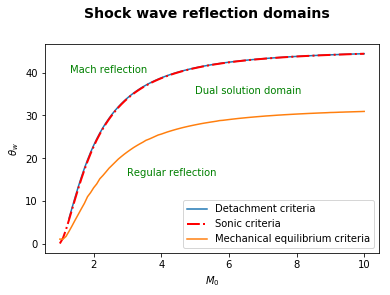

In [5]:
fig = plt.figure()
fig.suptitle('Shock wave reflection domains', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)

ax.set_xlabel(r'$M_0$')
ax.set_ylabel(r'$\theta_w$')

#ax.text(2, 6, r'an equation: $E=mc^2$', fontsize=15)


ax.text(3, 16, 'Regular reflection',
        color='green', fontsize=10)
ax.text(5, 35, 'Dual solution domain',
        color='green', fontsize=10)
ax.text(1.3, 40, 'Mach reflection',
        color='green', fontsize=10)


ax.plot(M0[3:],thetaD[3:],label= 'Detachment criteria')
ax.plot(M0,thetaS,'r-.',linewidth =2 ,label= 'Sonic criteria')
ax.plot(M0,thetavM,label= 'Mechanical equilibrium criteria')
ax.legend(loc='lower right')

plt.savefig("dualSoln.eps", format='eps', dpi=1000)
plt.show()